# ST4248 Group project: Classification of Customre Chrun problem

## 0. Description

+ Files
  + root repository
    + ipynb files (Code)
    + Data
      + Original
        + Contains: Original csv file, train set files
      + Processed
        + Contains: File after scailing and class imbalance
      + Output
        + Contains: Different model output files, test set files
  
+ Variable names:
  + For example: Xtrain_standard_df, means Xtrain file, after standardization scailing, variable type
  
+ Some code will only be run one time whenthe csv files are obtained and stored to the dataset, and then they will be marked
+ When doing training, dataframe type variable will be transformed to ndarry variables to increase training speed

## 1. Packages import and data loading

In [1]:
# Basics and visualization
import pandas as pd
import numpy as np
from numpy import vstack
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.pipeline import make_pipeline, Pipeline
import json
import seaborn as sns

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# ML Models to be considered
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

# Deep learning
import torch
from torch import nn
from torch.autograd import Variable
from torchvision.transforms import ToTensor, Lambda
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold

# Evaluation
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score
from sklearn.inspection import partial_dependence
from xgboost import plot_importance, plot_tree

# Warning ignorance
import warnings
warnings.filterwarnings("ignore")

c:\Users\asus\anaconda3\envs\pt-gpu\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
c:\Users\asus\anaconda3\envs\pt-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = "./Data/"

In [3]:
# Reading csv files from local repository
def read(pathname):
    df = pd.read_csv(pathname, header=[0])
    return df

def readdata(pathname):
    df = pd.read_csv(pathname, header=[0], index_col=[0])
    return df

## 2. Data visualization

In [4]:
Total_df = read(path + "Original/IT_customer_churn.csv")
Total_df.head(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [5]:
Total_df.dtypes
# TotalCharges is string type istead of float
Total_df["TotalCharges"] = pd.to_numeric(Total_df["TotalCharges"], errors='coerce')
Total_df = Total_df.dropna(axis=0, how='any')

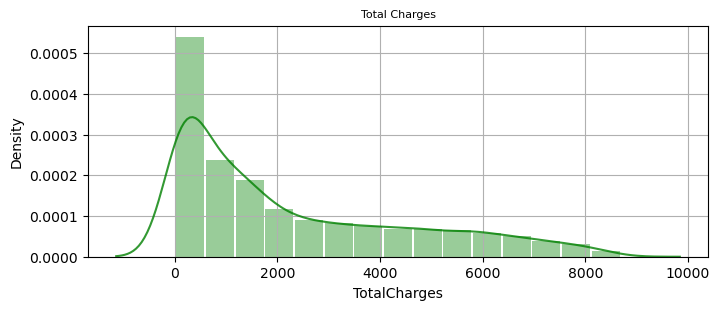

In [6]:
Total_df["TotalCharges"].hist(bins=15, density=True, color='g', alpha=0.4, rwidth=0.95, figsize=(8,3))
sns.kdeplot(Total_df["TotalCharges"], fill = False, color="green", alpha=.8)
plt.title('Total Charges', fontsize=8)
plt.show()

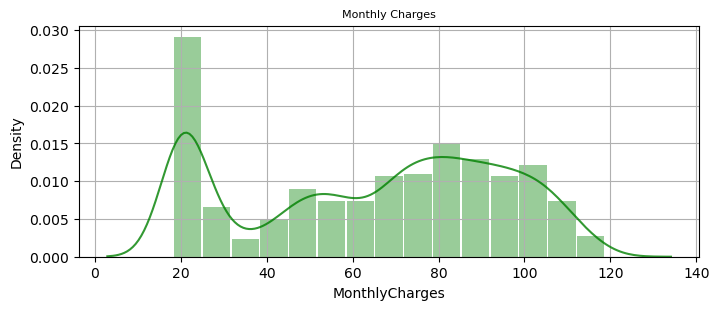

In [7]:
Total_df["MonthlyCharges"].hist(bins=15, density=True, color='g', alpha=0.4, rwidth=0.95, figsize=(8,3))
sns.kdeplot(Total_df["MonthlyCharges"], fill = False, color="green", alpha=.8)
plt.title("Monthly Charges", fontsize=8)
plt.show()

### 2.1 See the features' value

In [8]:
def print_unique_col_values(df):
    for column in df:
        if df[column].dtypes=='object':
            print(f'{column}: {df[column].unique()}') 


In [9]:
print_unique_col_values(Total_df)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


### 2.2 Categorical transformation

#### 2.2.1 Replace "No internet service" and "No phone service" to "No"; and also female and male

In [10]:
Total_df.replace('No internet service','No',inplace=True)
Total_df.replace('No phone service','No',inplace=True)

#### 2.2.2 Transform Yes to 1 and No to 0

In [11]:
yes_no_columns = ['Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
                  'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Churn']
for col in yes_no_columns:
    Total_df[col].replace({'Yes': 1,'No': 0},inplace=True)

Total_df['gender'].replace({'Female':1,'Male':0},inplace=True)

#### 2.2.3 Other categorical transformation

In [12]:
Total_df = pd.get_dummies(data=Total_df, columns=['InternetService','Contract','PaymentMethod'])
Total_df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

#### 2.2.4 Correlation HeatMap

<AxesSubplot: >

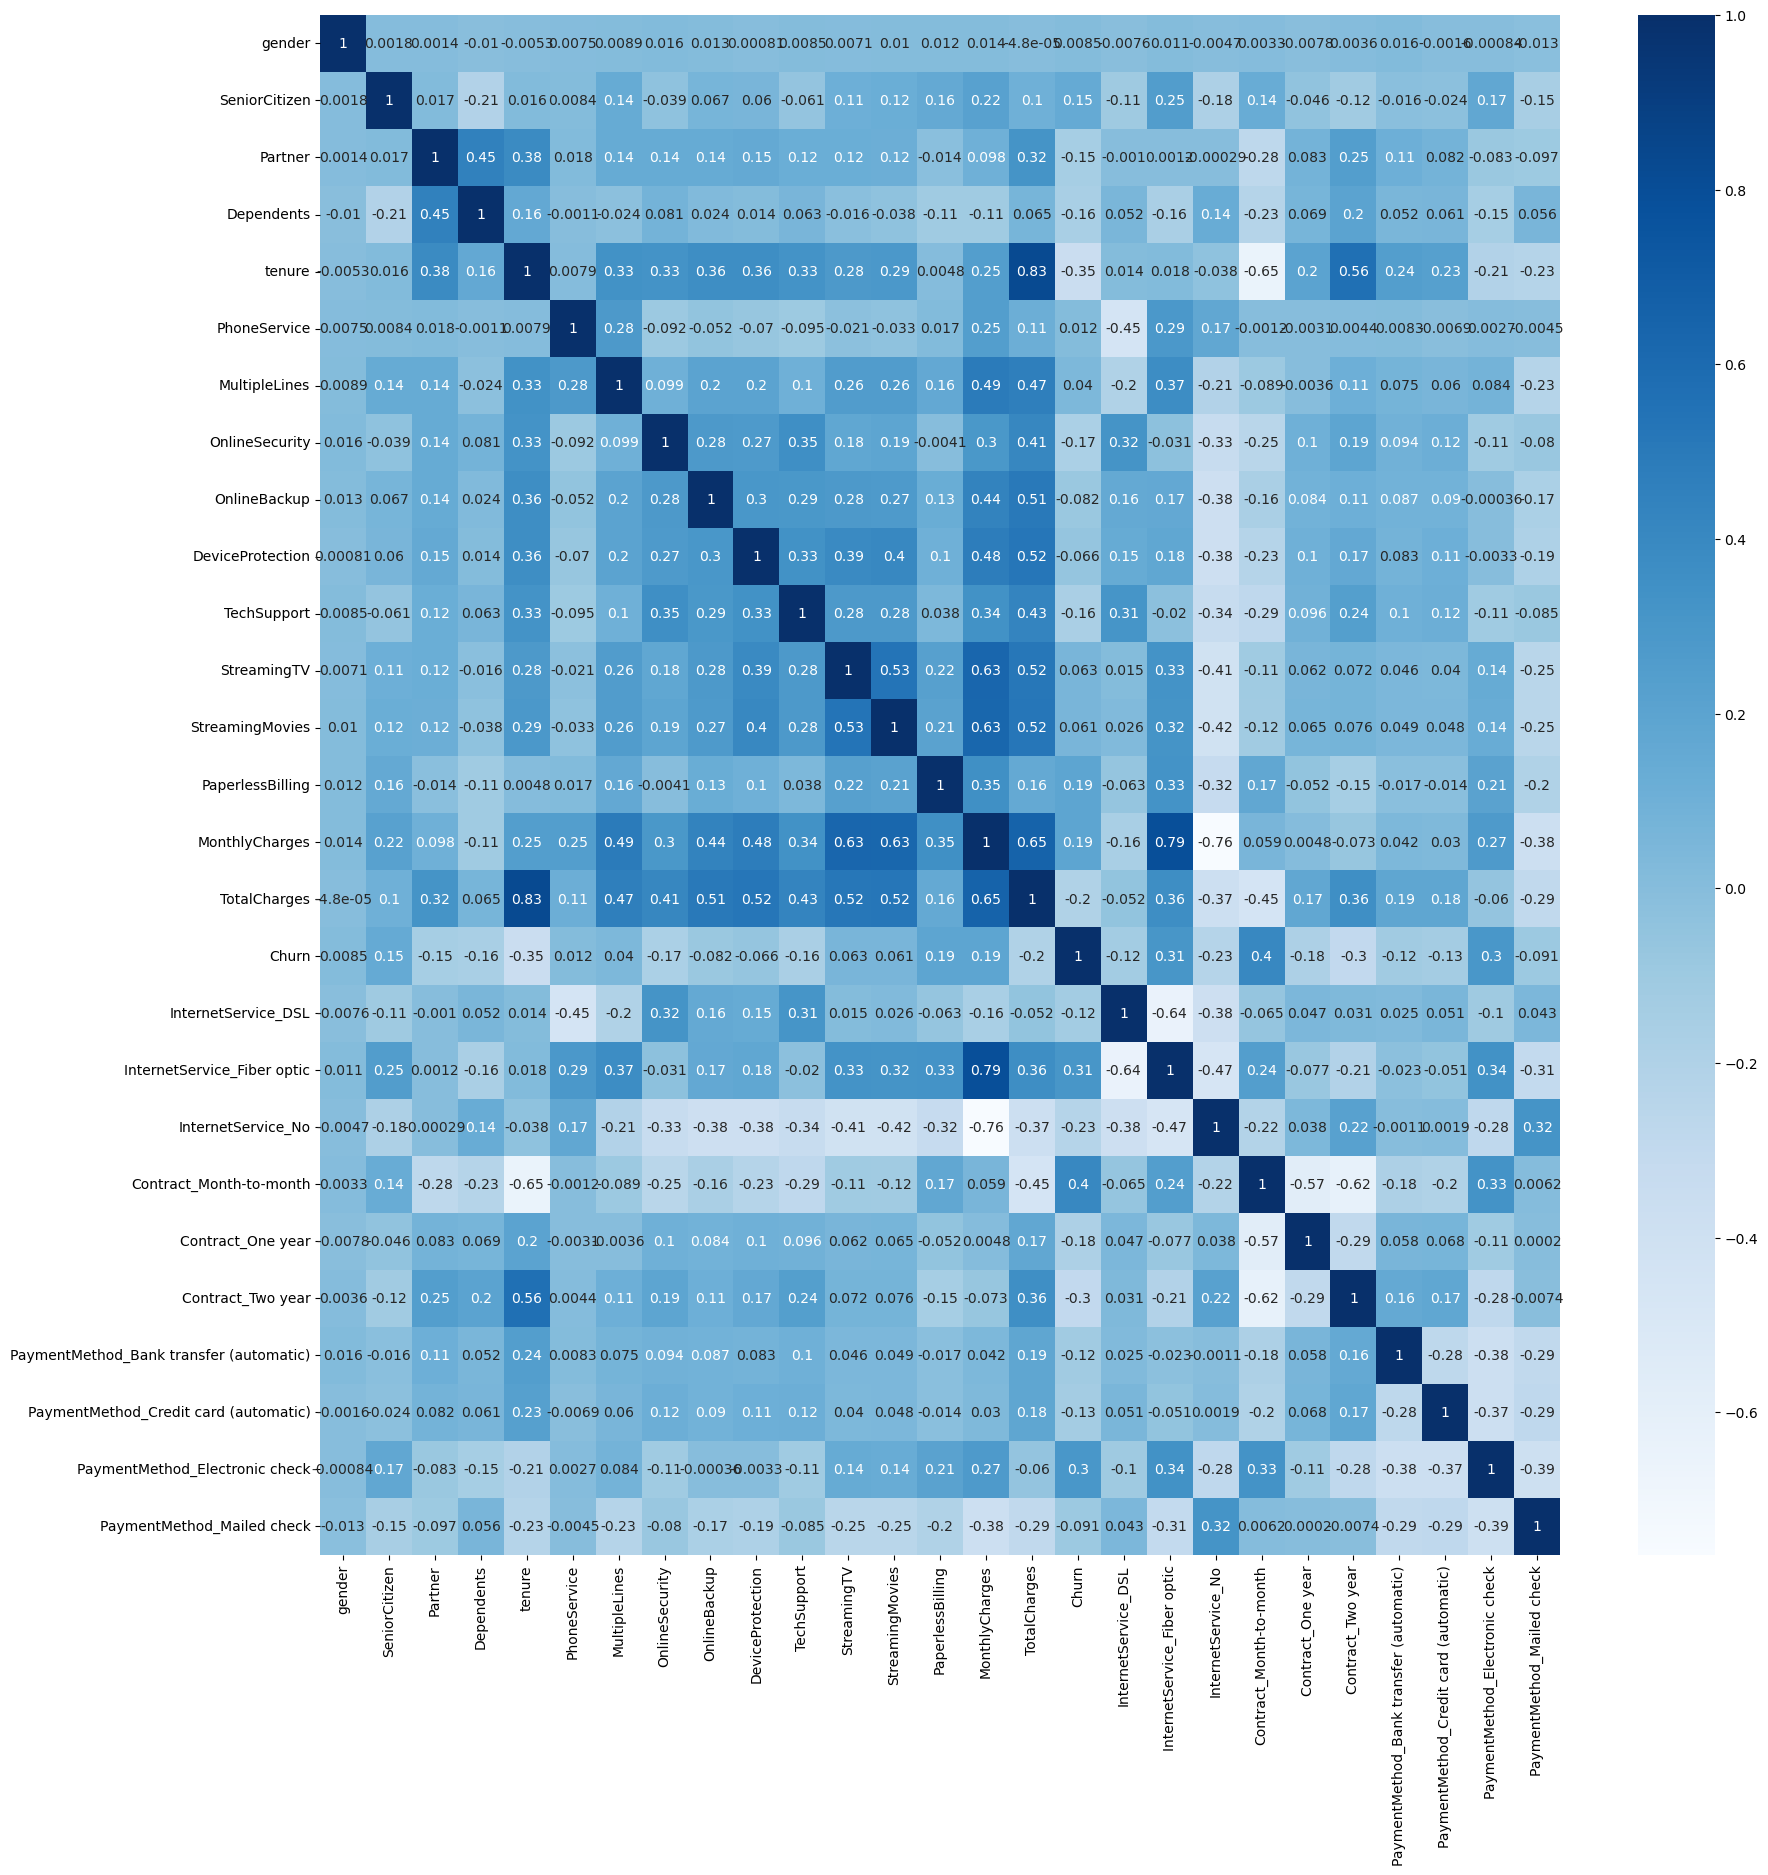

In [13]:
plt.figure(figsize=(20,20))
sns.heatmap(Total_df.corr(),cbar=True,annot=True,cmap='Blues')

### 2.3 Get the train and test csv file

In [14]:
Y_total = Total_df[["Churn"]]
X_total = Total_df.drop("Churn", axis = 1)
X_train, X_test, Y_train, Y_test = train_test_split(X_total, Y_total, test_size=0.3, random_state=101)
X_train.to_csv(path + "Original/X_train.csv")
X_test.to_csv(path + "Output/X_test.csv")
Y_train.to_csv(path + "Original/Y_train.csv")
Y_test.to_csv(path + "Output/Y_test.csv")

### 2.4 Class Imbalance

Look at the ratio of Y_train and X_train inside the dataframe

In [15]:
counts = Y_train['Churn'].value_counts()
print(counts)
print(counts/len(Y_train['Churn']))

0    3583
1    1339
Name: Churn, dtype: int64
0    0.727956
1    0.272044
Name: Churn, dtype: float64


In [16]:
counts = Y_test['Churn'].value_counts()
print(counts)
print(counts/len(Y_test['Churn']))

0    1580
1     530
Name: Churn, dtype: int64
0    0.748815
1    0.251185
Name: Churn, dtype: float64


We first deal with the imbalance problem in the dataset and then split them into train and test sets

#### 2.4.1 Undersample

In [17]:
rus = RandomUnderSampler(random_state=4248, replacement=True)
X_rus_train, Y_rus_train = rus.fit_resample(X_train, Y_train)

In [18]:
counts = Y_rus_train['Churn'].value_counts()
print(counts)
print(counts/len(Y_test['Churn']))

0    1339
1    1339
Name: Churn, dtype: int64
0    0.634597
1    0.634597
Name: Churn, dtype: float64


In [19]:
X_rus_train.to_csv(path + "Balanced/X_rus_train.csv")
Y_rus_train.to_csv(path + "Balanced/Y_rus_train.csv")

#### 2.4.2 Oversample

In [20]:
os = SMOTE(random_state = 4248)
X_os_train, Y_os_train = os.fit_resample(X_train, Y_train)

In [21]:
counts = Y_os_train['Churn'].value_counts()
print(counts)
print(counts/len(Y_test['Churn']))

1    3583
0    3583
Name: Churn, dtype: int64
1    1.698104
0    1.698104
Name: Churn, dtype: float64


In [22]:
X_os_train.to_csv(path + "Balanced/X_os_train.csv")
Y_os_train.to_csv(path + "Balanced/Y_os_train.csv")

### 2.5 Feature Selection

They are selected based on K Best Method

In [23]:
columns = ['tenure', 'OnlineSecurity', 'TechSupport', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'Contract_Month-to-month', 'Contract_One year']
X_train_selected_df = X_train.loc[:, columns]
X_test_selected_df = X_test.loc[:, columns]

In [24]:
X_train_selected_df.to_csv(path + "Feature_Engineering/X_train_selected.csv")
X_test_selected_df.to_csv(path + "Feature_Engineering/X_test_selected.csv")

### 2.6 Scaling

In [25]:
# We just need to scale the features named tenure, TotalCharges and Monthly Chargest
# The input are dataframe
def scaling(TrainData, TestData, scaler):
    TrainToBeScaled = TrainData.copy()
    TestToBeScaled = TestData.copy()
    cols_to_scale = ['tenure', 'TotalCharges', 'MonthlyCharges']

    TrainToBeScaled = scaler.fit_transform(TrainToBeScaled[cols_to_scale])
    TestToBeScaled = scaler.transform(TestToBeScaled[cols_to_scale])
    TrainIndex = TrainData.index
    TestIndex = TestData.index

    TrainToBeScaled = pd.DataFrame(TrainToBeScaled, columns = cols_to_scale,index = TrainIndex)
    TestToBeScaled = pd.DataFrame(TestToBeScaled, columns = cols_to_scale, index = TestIndex)  

    TrainData_Scaled = TrainData.drop(cols_to_scale, axis = 1)
    TrainData_Scaled = pd.concat([TrainData_Scaled, TrainToBeScaled], axis = 1)
    TestData_Scaled = TestData.drop(cols_to_scale, axis = 1)
    TestData_Scaled = pd.concat([TestData_Scaled, TestToBeScaled], axis = 1)

    return TrainData_Scaled, TestData_Scaled

## 3. Data preprocessing and class imbalance

### 3.1 Dataset are obtained directly from reading the csv file, instead of do the process in 2 again

In [26]:
X_train_df = readdata(path + "Original/X_train.csv")
X_test_df = readdata(path + "Output/X_test.csv")
Y_train_df = readdata(path + "Original/Y_train.csv")
Y_test_df = readdata(path + "Output/Y_test.csv")

In [27]:
X_rus_train_df = readdata(path + "Balanced/X_rus_train.csv")
Y_rus_train_df = readdata(path + "Balanced/Y_rus_train.csv")
X_os_train_df = readdata(path + "Balanced/X_os_train.csv")
Y_os_train_df = readdata(path + "Balanced/Y_os_train.csv")

In [28]:
# Transform df to ndarray to increase training spead
X_train_ndarray = X_train_df.values
X_test_ndarray = X_test_df.values
Y_train_ndarray = Y_train_df.values
Y_test_ndarray = Y_test_df.values

In [29]:
X_rus_train_ndarray = X_rus_train_df.values
Y_rus_train_ndarray = Y_rus_train_df.values
X_os_train_ndarray = X_os_train_df.values
Y_os_train_ndarray = Y_os_train_df.values

### 3.2 Data scaling and stored in the Processed repo

In [30]:
X_train_sc_df, X_test_sc_df = scaling(X_train_df, X_test_df, StandardScaler())
X_train_sc_df.to_csv(path + "Processed/X_train_sc.csv")
X_test_sc_df.to_csv(path+"Processed/X_test_sc.csv")

In [31]:
X_train_mmx_df, X_test_mmx_df = scaling(X_train_df, X_test_df, MinMaxScaler())
X_train_mmx_df.to_csv(path + "Processed/X_train_mmx.csv")
X_test_mmx_df.to_csv(path+"Processed/X_test_mmx.csv")

In [32]:
X_train_quantile_df, X_test_quantile_df = scaling(X_train_df, X_test_df, QuantileTransformer())
X_train_quantile_df.to_csv(path + "Processed/X_train_quantile.csv")
X_test_quantile_df.to_csv(path+"Processed/X_test_quantile.csv")

In [33]:
X_train_sc_ndarray = X_train_sc_df.values
X_test_sc_ndarray = X_test_sc_df.values
X_train_mmx_ndarray = X_train_mmx_df.values
X_test_mmx_ndarray = X_test_mmx_df.values
X_train_quantile_ndarray = X_train_quantile_df.values
X_test_quantile_ndarray = X_test_quantile_df.values

### 3.3 Balanced data scaling and stored in the Processed/Balanced repo

In [34]:
X_rus_train_sc_df, X_rus_test_sc_df = scaling(X_rus_train_df, X_test_df, StandardScaler())
X_rus_train_sc_df.to_csv(path + "Processed/Balanced/X_rus_train_sc.csv")
X_rus_test_sc_df.to_csv(path+"Processed/Balanced/X_rus_test_sc.csv")

X_rus_train_mmx_df, X_rus_test_mmx_df = scaling(X_rus_train_df, X_test_df, MinMaxScaler())
X_rus_train_mmx_df.to_csv(path + "Processed/Balanced/X_rus_train_mmx.csv")
X_rus_test_mmx_df.to_csv(path+"Processed/Balanced/X_rus_test_mmx.csv")

X_rus_train_quantile_df, X_rus_test_quantile_df = scaling(X_rus_train_df, X_test_df, QuantileTransformer())
X_rus_train_quantile_df.to_csv(path + "Processed/Balanced/X_rus_train_quantile.csv")
X_rus_test_quantile_df.to_csv(path+"Processed/Balanced/X_rus_test_quantile.csv")

In [35]:
X_os_train_sc_df, X_os_test_sc_df = scaling(X_os_train_df, X_test_df, StandardScaler())
X_os_train_sc_df.to_csv(path + "Processed/Balanced/X_os_train_sc.csv")
X_test_sc_df.to_csv(path+"Processed/Balanced/X_os_test_sc.csv")

X_os_train_mmx_df, X_os_test_mmx_df = scaling(X_os_train_df, X_test_df, MinMaxScaler())
X_os_train_mmx_df.to_csv(path + "Processed/Balanced/X_os_train_mmx.csv")
X_test_mmx_df.to_csv(path+"Processed/Balanced/X_os_test_mmx.csv")

X_os_train_quantile_df, X_os_test_quantile_df = scaling(X_os_train_df, X_test_df, QuantileTransformer())
X_os_train_quantile_df.to_csv(path + "Processed/Balanced/X_os_train_quantile.csv")
X_test_quantile_df.to_csv(path+"Processed/Balanced/X_os_test_quantile.csv")

In [36]:
X_rus_train_sc_ndarray = X_rus_train_sc_df.values
X_rus_test_sc_ndarray = X_rus_test_sc_df.values
X_rus_train_mmx_ndarray = X_rus_train_mmx_df.values
X_rus_test_mmx_ndarray = X_rus_test_mmx_df.values
X_rus_train_quantile_ndarray = X_rus_train_quantile_df.values
X_rus_test_quantile_ndarray = X_rus_test_quantile_df.values

X_os_train_sc_ndarray = X_os_train_sc_df.values
X_os_test_sc_ndarray = X_os_test_sc_df.values
X_os_train_mmx_ndarray = X_os_train_mmx_df.values
X_os_test_mmx_ndarray = X_os_test_mmx_df.values
X_os_train_quantile_ndarray = X_os_train_quantile_df.values
X_os_test_quantile_ndarray = X_os_test_quantile_df.values

### 3.4 Selected features data scaling

In [37]:
X_train_selected_sc_df, X_test_selected_sc_df = scaling(X_train_selected_df, X_test_selected_df, StandardScaler())
X_train_selected_sc_df.to_csv(path + "Processed/X_train_selected_sc.csv")
X_test_selected_sc_df.to_csv(path+"Processed/X_test_selected_sc.csv")

In [38]:
X_train_selected_mmx_df, X_test_selected_mmx_df = scaling(X_train_selected_df, X_test_selected_df, MinMaxScaler())
X_train_selected_mmx_df.to_csv(path + "Processed/X_train_selected_mmx.csv")
X_test_selected_mmx_df.to_csv(path+"Processed/X_test_selected_mmx.csv")

In [39]:
X_train_selected_quantile_df, X_test_selected_quantile_df = scaling(X_train_selected_df, X_test_selected_df, QuantileTransformer())
X_train_selected_quantile_df.to_csv(path + "Processed/X_train_selected_quantile.csv")
X_test_selected_quantile_df.to_csv(path+"Processed/X_test_selected_quantile.csv")

In [40]:
X_train_selected_sc_ndarray = X_train_selected_sc_df.values
X_test_selected_sc_ndarray = X_test_selected_sc_df.values
X_train_selected_mmx_ndarray = X_train_selected_mmx_df.values
X_test_selected_mmx_ndarray = X_test_selected_mmx_df.values
X_train_selected_quantile_ndarray = X_train_selected_quantile_df.values
X_test_selected_quantile_ndarray = X_test_selected_quantile_df.values

In [41]:
X_train_selected_ndarray = X_train_selected_df.values
X_test_selected_ndarray = X_test_selected_df.values

## 4. Model training and Model selection (Template, can be ignored)

In [42]:
def getScore(pipe_lr, X_valid, y_valid, prob=True):
    y_pred = pipe_lr.predict(X_valid)
    if prob:
        y_pred = pipe_lr.predict_proba(X_valid)[:,1]
    if (roc_auc_score(y_true=y_valid, y_score=y_pred) > 0.5):
        print('ROC: %.4f' % roc_auc_score(y_true=y_valid, y_score=y_pred))

### 4.1 Logistics Regression

#### 4.1.1 Original dataset

In [ ]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# Define a Standard Scaler to normalize inputs

# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(class_weight="balanced")
pipe = Pipeline(steps=[("pca", pca), ("logistic", logistic)])


# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = [
    {
        "logistic__solver": ['liblinear'],
        "pca__n_components": [0.8, 0.85, 0.9, 0.95, 1],
        "logistic__C": [1e-4, 0.001, 0.01, 1, 10, 100, 1000],
        "logistic__tol": [1e-3, 1e-2, 0.1],
        "logistic__max_iter": [100, 1000, 10000],
        "logistic__penalty": ['l2', 'l1']
    },
    {
        "logistic__solver": ['newton-cg', 'lbfgs', 'sag'],
        "pca__n_components": [0.8, 0.85, 0.9, 0.95, 1],
        "logistic__C": [1e-4, 0.001, 0.01, 1, 10, 100, 1000],
        "logistic__tol": [1e-3, 1e-2, 0.1],
        "logistic__max_iter": [100, 1000, 10000],
        "logistic__penalty": ['l2'] 
    },
    {
        "logistic__solver": ['saga'],
        "pca__n_components": [0.8, 0.85, 0.9, 0.95, 1],
        "logistic__l1_ratio": [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1],
        "logistic__C": [1e-4, 0.001, 0.01, 1, 10, 100, 1000],
        "logistic__tol": [1e-3, 1e-2, 0.1],
        "logistic__max_iter": [100, 1000, 10000],
        "logistic__penalty": ['elasticnet']
    },
    {
        
    }
]
search = GridSearchCV(pipe, param_grid[:-1], n_jobs=10, scoring='roc_auc', cv=5) #use -1 to skip this step
search.fit(X_train_ndarray, Y_train_ndarray)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/LogisticsRegression.csv")
# params_top5 = results.loc[:5, 'params']
results.head(10)

Best parameter (CV score=0.652):
{'logistic__C': 0.0001, 'logistic__max_iter': 100, 'logistic__penalty': 'l2', 'logistic__solver': 'liblinear', 'logistic__tol': 0.001, 'pca__n_components': 0.8}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_logistic__max_iter,param_logistic__penalty,param_logistic__solver,param_logistic__tol,param_pca__n_components,param_logistic__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.068364,0.000749,0.002261,0.000409,0.0001,100,l2,liblinear,0.001,0.8,NaN,"{'logistic__C': 0.0001, 'logistic__max_iter': ...",0.641057,0.644281,0.657436,0.654106,0.661344,0.651645,0.007746,1
2930,0.010719,0.001712,0.001800,0.000750,1,100,elasticnet,saga,0.01,0.8,0.2,"{'logistic__C': 1, 'logistic__l1_ratio': 0.2, ...",0.641057,0.644281,0.657436,0.654106,0.661344,0.651645,0.007746,1
2931,0.012137,0.002069,0.002407,0.000487,1,100,elasticnet,saga,0.01,0.85,0.2,"{'logistic__C': 1, 'logistic__l1_ratio': 0.2, ...",0.641057,0.644281,0.657436,0.654106,0.661344,0.651645,0.007746,1
2932,0.013157,0.001874,0.001830,0.000421,1,100,elasticnet,saga,0.01,0.9,0.2,"{'logistic__C': 1, 'logistic__l1_ratio': 0.2, ...",0.641057,0.644281,0.657436,0.654106,0.661344,0.651645,0.007746,1
2933,0.011936,0.001360,0.002206,0.000402,1,100,elasticnet,saga,0.01,0.95,0.2,"{'logistic__C': 1, 'logistic__l1_ratio': 0.2, ...",0.641057,0.644281,0.657436,0.654106,0.661344,0.651645,0.007746,1
2934,0.023412,0.002000,0.002691,0.000776,1,100,elasticnet,saga,0.01,1,0.2,"{'logistic__C': 1, 'logistic__l1_ratio': 0.2, ...",0.641057,0.644281,0.657436,0.654106,0.661344,0.651645,0.007746,1
2935,0.010676,0.000998,0.002373,0.000514,1,100,elasticnet,saga,0.1,0.8,0.2,"{'logistic__C': 1, 'logistic__l1_ratio': 0.2, ...",0.641057,0.644281,0.657436,0.654106,0.661344,0.651645,0.007746,1
2936,0.010019,0.001802,0.001821,0.000411,1,100,elasticnet,saga,0.1,0.85,0.2,"{'logistic__C': 1, 'logistic__l1_ratio': 0.2, ...",0.641057,0.644281,0.657436,0.654106,0.661344,0.651645,0.007746,1
2937,0.012271,0.002012,0.002292,0.000514,1,100,elasticnet,saga,0.1,0.9,0.2,"{'logistic__C': 1, 'logistic__l1_ratio': 0.2, ...",0.641057,0.644281,0.657436,0.654106,0.661344,0.651645,0.007746,1
2938,0.011144,0.001856,0.001904,0.000659,1,100,elasticnet,saga,0.1,0.95,0.2,"{'logistic__C': 1, 'logistic__l1_ratio': 0.2, ...",0.641057,0.644281,0.657436,0.654106,0.661344,0.651645,0.007746,1


In [ ]:
Best_pca = PCA(0.8)
Best_logisticsRegression = LogisticRegression(C= 0.0001, max_iter = 100, penalty= 'l2', 
solver= 'liblinear', tol= 0.001)
Best_pipe = Pipeline([('pca', Best_pca), ('logistic', Best_logisticsRegression)])
pipe.fit(X_train_ndarray, Y_train_ndarray)
prediction = pipe.predict(X_test_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print(auc_score)

0.7560902794363507


The best result is 0.737333

#### 4.1.2 Standard Scaling

In [ ]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# Define a Standard Scaler to normalize inputs
sc = StandardScaler()
# set the tolerance to a large value to make the example faster
logistic = LogisticRegression()
pipe = Pipeline(steps=[("scaler", sc) , ("pca", pca), ("logistic", logistic)])


# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = [
    {
        "logistic__solver": ['liblinear'],
        "pca__n_components": [0.8, 0.85, 0.9, 0.95, 1],
        "logistic__C": [1e-4, 0.001, 0.01, 1, 10, 100, 1000],
        "logistic__tol": [1e-3, 1e-2, 0.1],
        "logistic__max_iter": [100, 1000, 10000],
        "logistic__penalty": ['l2', 'l1']
    },
    {
        "logistic__solver": ['newton-cg', 'lbfgs', 'sag'],
        "pca__n_components": [0.8, 0.85, 0.9, 0.95, 1],
        "logistic__C": [1e-4, 0.001, 0.01, 1, 10, 100, 1000],
        "logistic__tol": [1e-3, 1e-2, 0.1],
        "logistic__max_iter": [100, 1000, 10000],
        "logistic__penalty": ['l2'] 
    },
    {
        "logistic__solver": ['saga'],
        "pca__n_components": [0.8, 0.85, 0.9, 0.95, 1],
        "logistic__l1_ratio": [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1],
        "logistic__C": [1e-4, 0.001, 0.01, 1, 10, 100, 1000],
        "logistic__tol": [1e-3, 1e-2, 0.1],
        "logistic__max_iter": [100, 1000, 10000],
        "logistic__penalty": ['elasticnet']
    },
    {
        
    }
]
search = GridSearchCV(pipe, param_grid[:-1], n_jobs=10, scoring='roc_auc', cv=5) #use -1 to skip this step
search.fit(X_train_ndarray, Y_train_ndarray)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/LogisticsRegression_StandardScaling.csv")
# params_top5 = results.loc[:5, 'params']
results.head(10)

Best parameter (CV score=0.846):
{'logistic__C': 100, 'logistic__l1_ratio': 0.05, 'logistic__max_iter': 10000, 'logistic__penalty': 'elasticnet', 'logistic__solver': 'saga', 'logistic__tol': 0.1, 'pca__n_components': 0.85}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_logistic__max_iter,param_logistic__penalty,param_logistic__solver,param_logistic__tol,param_pca__n_components,param_logistic__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3686,0.016682,0.001550,0.002992,0.000780,100,10000,elasticnet,saga,0.1,0.85,0.05,"{'logistic__C': 100, 'logistic__l1_ratio': 0.0...",0.837923,0.834403,0.848594,0.857271,0.853593,0.846357,0.008838,1
4093,0.018953,0.001756,0.002306,0.000613,1000,10000,elasticnet,saga,0.1,0.95,0.05,"{'logistic__C': 1000, 'logistic__l1_ratio': 0....",0.838355,0.834538,0.848354,0.858918,0.851279,0.846289,0.008828,2
3673,0.018938,0.003888,0.002404,0.000581,100,1000,elasticnet,saga,0.1,0.95,0.05,"{'logistic__C': 100, 'logistic__l1_ratio': 0.0...",0.837606,0.834548,0.848620,0.858365,0.850793,0.845987,0.008767,3
3523,0.015576,0.001632,0.001705,0.000398,10,100,elasticnet,saga,0.1,0.95,0.95,"{'logistic__C': 10, 'logistic__l1_ratio': 0.95...",0.837871,0.835126,0.847510,0.857948,0.851399,0.845971,0.008468,4
4078,0.017815,0.001703,0.002513,0.000450,1000,1000,elasticnet,saga,0.1,0.95,0.05,"{'logistic__C': 1000, 'logistic__l1_ratio': 0....",0.837934,0.834996,0.847458,0.858657,0.850767,0.845962,0.008616,5
4228,0.018454,0.002446,0.002818,0.000527,1000,10000,elasticnet,saga,0.1,0.95,0.5,"{'logistic__C': 1000, 'logistic__l1_ratio': 0....",0.837262,0.834304,0.847145,0.859371,0.851702,0.845957,0.009228,6
4183,0.019761,0.003802,0.003126,0.000375,1000,10000,elasticnet,saga,0.1,0.95,0.2,"{'logistic__C': 1000, 'logistic__l1_ratio': 0....",0.838334,0.834205,0.847640,0.858730,0.850762,0.845934,0.008778,7
1482,0.023208,0.003336,0.003121,0.000738,1000,100,l2,sag,0.1,0.9,NaN,"{'logistic__C': 1000, 'logistic__max_iter': 10...",0.838272,0.833763,0.848328,0.857938,0.851321,0.845924,0.008783,8
3011,0.016485,0.003719,0.003753,0.002391,1,10000,elasticnet,saga,0.1,0.85,0.5,"{'logistic__C': 1, 'logistic__l1_ratio': 0.5, ...",0.838308,0.834153,0.847739,0.856682,0.852642,0.845905,0.008494,9
2923,0.018995,0.006253,0.002417,0.003907,1,10000,elasticnet,saga,0.1,0.95,0.1,"{'logistic__C': 1, 'logistic__l1_ratio': 0.1, ...",0.837731,0.834663,0.847963,0.857849,0.851300,0.845901,0.008593,10


In [ ]:
Best_pca = PCA(0.95)
Best_logisticsRegression = LogisticRegression(C= 1000, max_iter = 10000, penalty= 'l2', 
solver= 'sag', tol= 0.1)
Best_pipe = Pipeline([("scaler", sc), ('pca', Best_pca), ('logistic', Best_logisticsRegression)])
pipe.fit(X_train_ndarray, Y_train_ndarray)
prediction = pipe.predict(X_test_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print(auc_score)

0.7182230714115118


The best result is 0.734668

#### 4.1.3 Min Max Scaling

In [ ]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# Define a MinMax Scaler to normalize inputs
mmx = MinMaxScaler()
# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(class_weight="balanced")
pipe = Pipeline(steps=[("scaler", mmx) , ("pca", pca), ("logistic", logistic)])


# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = [
    {
        "logistic__solver": ['liblinear'],
        "pca__n_components": [0.8, 0.85, 0.9, 0.95, 1],
        "logistic__C": [1e-4, 0.001, 0.01, 1, 10, 100, 1000],
        "logistic__tol": [1e-3, 1e-2, 0.1],
        "logistic__max_iter": [100, 1000, 10000],
        "logistic__penalty": ['l2', 'l1']
    },
    {
        "logistic__solver": ['newton-cg', 'lbfgs', 'sag'],
        "pca__n_components": [0.8, 0.85, 0.9, 0.95, 1],
        "logistic__C": [1e-4, 0.001, 0.01, 1, 10, 100, 1000],
        "logistic__tol": [1e-3, 1e-2, 0.1],
        "logistic__max_iter": [100, 1000, 10000],
        "logistic__penalty": ['l2'] 
    },
    {
        "logistic__solver": ['saga'],
        "pca__n_components": [0.8, 0.85, 0.9, 0.95, 1],
        "logistic__l1_ratio": [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1],
        "logistic__C": [1e-4, 0.001, 0.01, 1, 10, 100, 1000],
        "logistic__tol": [1e-3, 1e-2, 0.1],
        "logistic__max_iter": [100, 1000, 10000],
        "logistic__penalty": ['elasticnet']
    },
    {
        
    }
]
search = GridSearchCV(pipe, param_grid[:-1], n_jobs=10, scoring='roc_auc', cv=5) #use -1 to skip this step
search.fit(X_train_ndarray, Y_train_ndarray)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/LogisticsRegression_MinMaxScaling.csv")
# params_top5 = results.loc[:5, 'params']
results.head(10)

Best parameter (CV score=0.842):
{'logistic__C': 10, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'sag', 'logistic__tol': 0.1, 'pca__n_components': 0.85}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_logistic__max_iter,param_logistic__penalty,param_logistic__solver,param_logistic__tol,param_pca__n_components,param_logistic__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1301,0.021551,0.002319,0.002403,0.000798,10,10000,l2,sag,0.1,0.85,NaN,"{'logistic__C': 10, 'logistic__max_iter': 1000...",0.832126,0.828975,0.844300,0.853852,0.849827,0.841816,0.009737,1
3341,0.019164,0.002639,0.002502,0.000999,10,100,elasticnet,saga,0.1,0.85,0.2,"{'logistic__C': 10, 'logistic__l1_ratio': 0.2,...",0.832886,0.829542,0.844842,0.853196,0.847920,0.841677,0.009013,2
3881,0.018252,0.002973,0.001817,0.001958,100,100,elasticnet,saga,0.1,0.85,0.9,"{'logistic__C': 100, 'logistic__l1_ratio': 0.9...",0.833250,0.829074,0.846051,0.852497,0.846980,0.841570,0.008878,3
4136,0.018833,0.002356,0.000703,0.001406,1000,10000,elasticnet,saga,0.1,0.85,0.1,"{'logistic__C': 1000, 'logistic__l1_ratio': 0....",0.832339,0.829308,0.843956,0.853144,0.849017,0.841553,0.009281,4
3506,0.015120,0.005050,0.002014,0.002643,10,10000,elasticnet,saga,0.1,0.85,0.9,"{'logistic__C': 10, 'logistic__l1_ratio': 0.9,...",0.833370,0.827481,0.846838,0.851325,0.848328,0.841468,0.009319,5
4017,0.014132,0.003851,0.001910,0.002345,1000,100,elasticnet,saga,0.1,0.9,0,"{'logistic__C': 1000, 'logistic__l1_ratio': 0,...",0.833911,0.830167,0.844097,0.851351,0.847800,0.841465,0.008118,6
3896,0.019920,0.000413,0.001406,0.001967,100,1000,elasticnet,saga,0.1,0.85,0.9,"{'logistic__C': 100, 'logistic__l1_ratio': 0.9...",0.833021,0.828605,0.845337,0.852169,0.847487,0.841324,0.008971,7
3701,0.015225,0.003670,0.003432,0.003098,100,100,elasticnet,saga,0.1,0.85,0.1,"{'logistic__C': 100, 'logistic__l1_ratio': 0.1...",0.832626,0.828933,0.844915,0.852263,0.847868,0.841321,0.008995,8
4287,0.019589,0.000572,0.004511,0.004583,1000,100,elasticnet,saga,0.1,0.9,0.9,"{'logistic__C': 1000, 'logistic__l1_ratio': 0....",0.833713,0.828127,0.844008,0.852466,0.848103,0.841283,0.009049,9
4363,0.018008,0.004518,0.002003,0.004005,1000,10000,elasticnet,saga,0.1,0.95,0.95,"{'logistic__C': 1000, 'logistic__l1_ratio': 0....",0.833968,0.827778,0.846014,0.851288,0.847346,0.841279,0.008890,10


In [ ]:
Best_pca = PCA(0.8)
Best_logisticsRegression = LogisticRegression(C= 1000, l1_ratio = 1, max_iter = 1000, penalty= 'elasticnet', 
solver= 'sega', tol= 0.1)
Best_pipe = Pipeline([("scaler", mmx), ('pca', Best_pca), ('logistic', Best_logisticsRegression)])
pipe.fit(X_train_ndarray, Y_train_ndarray)
prediction = pipe.predict(X_test_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print(auc_score)

0.7548363983759254


The best result is: 0.736928

#### 4.1.4 Quantile Scaling

In [ ]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# Define a Quantile Scaler to normalize inputs
qt = QuantileTransformer()
# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(class_weight="balanced")
pipe = Pipeline(steps=[("scaler", qt) , ("pca", pca), ("logistic", logistic)])


# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = [
    {
        "logistic__solver": ['liblinear'],
        "pca__n_components": [0.8, 0.85, 0.9, 0.95, 1],
        "logistic__C": [1e-4, 0.001, 0.01, 1, 10, 100, 1000],
        "logistic__tol": [1e-3, 1e-2, 0.1],
        "logistic__max_iter": [100, 1000, 10000],
        "logistic__penalty": ['l2', 'l1']
    },
    {
        "logistic__solver": ['newton-cg', 'lbfgs', 'sag'],
        "pca__n_components": [0.8, 0.85, 0.9, 0.95, 1],
        "logistic__C": [1e-4, 0.001, 0.01, 1, 10, 100, 1000],
        "logistic__tol": [1e-3, 1e-2, 0.1],
        "logistic__max_iter": [100, 1000, 10000],
        "logistic__penalty": ['l2'] 
    },
    {
        "logistic__solver": ['saga'],
        "pca__n_components": [0.8, 0.85, 0.9, 0.95, 1],
        "logistic__l1_ratio": [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1],
        "logistic__C": [1e-4, 0.001, 0.01, 1, 10, 100, 1000],
        "logistic__tol": [1e-3, 1e-2, 0.1],
        "logistic__max_iter": [100, 1000, 10000],
        "logistic__penalty": ['elasticnet']
    },
    {
        
    }
]
search = GridSearchCV(pipe, param_grid[:-1], n_jobs=10, scoring='roc_auc', cv=5) #use -1 to skip this step
search.fit(X_train_ndarray, Y_train_ndarray)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/LogisticsRegression_MinMaxScaling.csv")
# params_top5 = results.loc[:5, 'params']
results.head(10)

Best parameter (CV score=0.843):
{'logistic__C': 1000, 'logistic__l1_ratio': 1, 'logistic__max_iter': 100, 'logistic__penalty': 'elasticnet', 'logistic__solver': 'saga', 'logistic__tol': 0.1, 'pca__n_components': 0.9}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_logistic__max_iter,param_logistic__penalty,param_logistic__solver,param_logistic__tol,param_pca__n_components,param_logistic__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4377,0.339251,0.015310,0.006111,0.001029,1000,100,elasticnet,saga,0.1,0.9,1,"{'logistic__C': 1000, 'logistic__l1_ratio': 1,...",0.835238,0.831395,0.847609,0.853540,0.848803,0.843317,0.008490,1
1392,0.364838,0.019241,0.005102,0.000798,100,1000,l2,sag,0.1,0.9,NaN,"{'logistic__C': 100, 'logistic__max_iter': 100...",0.833932,0.833081,0.845483,0.854050,0.849811,0.843271,0.008425,2
3762,0.391875,0.020530,0.006719,0.001444,100,1000,elasticnet,saga,0.1,0.9,0.2,"{'logistic__C': 100, 'logistic__l1_ratio': 0.2...",0.835150,0.829344,0.849126,0.852779,0.849879,0.843255,0.009255,3
3898,0.331950,0.043884,0.005601,0.001200,100,1000,elasticnet,saga,0.1,0.95,0.9,"{'logistic__C': 100, 'logistic__l1_ratio': 0.9...",0.835514,0.830437,0.845149,0.855301,0.849623,0.843205,0.009093,4
4213,0.344953,0.015753,0.005609,0.001396,1000,1000,elasticnet,saga,0.1,0.95,0.5,"{'logistic__C': 1000, 'logistic__l1_ratio': 0....",0.834869,0.830364,0.844951,0.856317,0.849278,0.843156,0.009447,5
4107,0.356890,0.016153,0.006111,0.000587,1000,100,elasticnet,saga,0.1,0.9,0.1,"{'logistic__C': 1000, 'logistic__l1_ratio': 0....",0.834546,0.829230,0.845733,0.855317,0.849942,0.842953,0.009679,6
3837,0.352929,0.043765,0.005600,0.000489,100,100,elasticnet,saga,0.1,0.9,0.8,"{'logistic__C': 100, 'logistic__l1_ratio': 0.8...",0.834754,0.831853,0.842148,0.855530,0.849874,0.842832,0.008912,7
4017,0.375481,0.022392,0.006003,0.000633,1000,100,elasticnet,saga,0.1,0.9,0,"{'logistic__C': 1000, 'logistic__l1_ratio': 0,...",0.834405,0.829662,0.846150,0.854493,0.849357,0.842813,0.009317,8
3747,0.333198,0.013233,0.006149,0.000363,100,100,elasticnet,saga,0.1,0.9,0.2,"{'logistic__C': 100, 'logistic__l1_ratio': 0.2...",0.835040,0.831712,0.845723,0.853060,0.848531,0.842813,0.008122,9
3147,0.327164,0.021045,0.005802,0.000747,1,10000,elasticnet,saga,0.1,0.9,0.95,"{'logistic__C': 1, 'logistic__l1_ratio': 0.95,...",0.834234,0.830822,0.845780,0.853508,0.849660,0.842801,0.008803,10


In [ ]:
Best_pca = PCA(0.8)
Best_logisticsRegression = LogisticRegression(C= 1000, l1_ratio = 0.1, max_iter = 100, penalty= 'elasticnet', 
solver= 'sega', tol= 0.1)
Best_pipe = Pipeline([("scaler", qt), ('pca', Best_pca), ('logistic', Best_logisticsRegression)])
pipe.fit(X_train_ndarray, Y_train_ndarray)
prediction = pipe.predict(X_test_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print(auc_score)

0.7611595414377836


The best result is: 0.734404

## 5. Ensemble Learning

### 5.1 Adaboost

#### 5.1.1 Initial trails without tuning

In [ ]:
class AdaBoost:
    def __init__(self, n_estimators=50, learning_rate=1.0, random_state=None):
        self.model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=random_state)

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
    
    def predict(self, X_test):
        return self.model.predict(X_test)
    
    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        return accuracy

In [ ]:
ada = AdaBoost()
ada.train(X_train_ndarray, Y_train_ndarray)
accuracy = ada.evaluate(X_test_ndarray, Y_test_ndarray)
print(f"Accuracy: {accuracy:.8f}")

Accuracy: 0.80995261


In [ ]:
ada = AdaBoost()
ada.train(X_rus_train_ndarray, Y_rus_train_ndarray)
accuracy = ada.evaluate(X_test_ndarray, Y_test_ndarray)
print(f"Accuracy: {accuracy:.8f}")

Accuracy: 0.73317536


In [ ]:
ada = AdaBoost()
ada.train(X_os_train_ndarray, Y_os_train_ndarray)
accuracy = ada.evaluate(X_test_ndarray, Y_test_ndarray)
print(f"Accuracy: {accuracy:.8f}")

Accuracy: 0.78009479


The code below is for reference only if you want to create your own class that is suitable for paramter tuning

In [ ]:
# class Adaboost(BaseEstimator, ClassifierMixin):
#     def __init__(self, n_estimators=50, learning_rate=1.0, max_depth=1):
#         self.n_estimators = n_estimators
#         self.learning_rate = learning_rate
#         self.max_depth = max_depth
#         self.base_estimator = DecisionTreeClassifier(max_depth=self.max_depth)
#         self.estimators_ = []
#         self.estimator_weights_ = np.zeros(self.n_estimators)
#         self.estimator_errors_ = np.ones(self.n_estimators)

#     def fit(self, X, y):
#         self.estimators_ = []
#         self.estimator_weights_ = np.zeros(self.n_estimators)
#         self.estimator_errors_ = np.ones(self.n_estimators)

#         # Initialize weights to 1/n_samples
#         sample_weight = np.full(X.shape[0], 1 / X.shape[0])

#         for i in range(self.n_estimators):
#             # Fit a weak learner to the training data using the current sample weights
#             estimator = clone(self.base_estimator)
#             estimator.fit(X, y, sample_weight=sample_weight)

#             # Compute the weighted error of the estimator
#             y_pred = estimator.predict(X)
#             incorrect = y_pred != y
#             estimator_error = np.average(incorrect, weights=sample_weight, axis=0)

#             # Compute the weight of the estimator
#             estimator_weight = self.learning_rate * np.log((1 - estimator_error) / estimator_error)

#             # Update the sample weights
#             sample_weight *= np.exp(estimator_weight * incorrect * ((sample_weight > 0) | (estimator_weight < 0)))

#             # Save the trained estimator and its weight
#             self.estimators_.append(estimator)
#             self.estimator_weights_[i] = estimator_weight
#             self.estimator_errors_[i] = estimator_error

#         return self

#     def predict(self, X):
#         # Compute the weighted votes of the estimators
#         y_pred = np.zeros((X.shape[0], 2))
#         for i, estimator in enumerate(self.estimators_):
#             y_pred += self.estimator_weights_[i] * np.eye(2)[estimator.predict(X)]

#         # Return the class with the highest weighted vote
#         return np.argmax(y_pred, axis=1)

#     def set_params(self, **params):
#         for param, value in params.items():
#             setattr(self, param, value)
#         return self


The test accuracy is 0.77896233

#### 5.1.2 Tuning with CV

In [ ]:
pca = PCA()

pipe = Pipeline([
    ('pca', PCA()),
    ('model', AdaBoostClassifier())
])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'pca__n_components': ['mle', 50, 100],
    'model__n_estimators': [50, 100, 200, 500],
    'model__learning_rate': [0.01, 0.05, 0.1, 1.0]

}
search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
search.fit(X_train_ndarray, Y_train_ndarray)

print("Best parameter (CV score=%0.4f):" % search.best_score_)
print(search.best_params_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/AdaBoost_ROCAUC.csv")
results.head(10)

Best parameter (CV score=0.8458):
{'model__learning_rate': 0.05, 'model__n_estimators': 500, 'pca__n_components': 'mle'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
21,11.775577,0.210256,0.189882,0.015860,0.05,500,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.849190,0.842591,0.838578,0.850225,0.848168,0.845751,0.004453,1
30,4.790024,0.140035,0.071678,0.003117,0.1,200,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.847637,0.842149,0.837504,0.850837,0.845423,0.844710,0.004585,2
27,2.395861,0.094354,0.041490,0.005546,0.1,100,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.842914,0.837554,0.832707,0.844141,0.843235,0.840110,0.004364,3
18,4.697786,0.143653,0.075592,0.005710,0.05,200,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.842891,0.836817,0.832733,0.843951,0.841649,0.839608,0.004215,4
33,11.224164,0.091124,0.120966,0.009059,0.1,500,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.842329,0.836562,0.835430,0.834383,0.840437,0.837828,0.003043,5
36,1.220225,0.042183,0.019546,0.001489,1.0,50,mle,"{'model__learning_rate': 1.0, 'model__n_estima...",0.841847,0.818361,0.827827,0.839615,0.831510,0.831832,0.008467,6
15,2.394026,0.077070,0.041513,0.009857,0.05,100,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.832886,0.825447,0.822326,0.829601,0.833122,0.828676,0.004221,7
24,1.215782,0.033152,0.020539,0.000885,0.1,50,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.833773,0.825545,0.822451,0.828773,0.832827,0.828674,0.004284,8
9,11.970073,0.097230,0.197672,0.017988,0.01,500,mle,"{'model__learning_rate': 0.01, 'model__n_estim...",0.832745,0.824944,0.822196,0.829578,0.832787,0.828450,0.004241,9
39,2.391943,0.073145,0.037392,0.001160,1.0,100,mle,"{'model__learning_rate': 1.0, 'model__n_estima...",0.836383,0.819696,0.822480,0.822699,0.828136,0.825879,0.005922,10


In [ ]:
Best_AdaBoost = AdaBoostClassifier(n_estimators=500, learning_rate=0.05)
Best_AdaBoost.fit(X_train_ndarray, Y_train_ndarray)
prediction = Best_AdaBoost.predict(X_test_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

ROC_AUC: 0.720133747313112
Accuracy: 0.8109004739336493


- ROC_AUC: 0.6736365235749472
- Accuracy: 0.7697228144989339

In [ ]:
pca = PCA()

pipe = Pipeline([
    ('pca', PCA()),
    ('model', AdaBoostClassifier())
])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'pca__n_components': ['mle', 50, 100],
    'model__n_estimators': [50, 100, 200, 500],
    'model__learning_rate': [0.01, 0.05, 0.1, 1.0]

}
search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
search.fit(X_train_ndarray, Y_train_ndarray)

print("Best parameter (CV score=%0.4f):" % search.best_score_)
print(search.best_params_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/AdaBoost_Accuracy.csv")
results.head(10)

Best parameter (CV score=0.7976):
{'model__learning_rate': 0.1, 'model__n_estimators': 500, 'pca__n_components': 'mle'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
33,9.238438,1.970471,0.121746,0.033751,0.1,500,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.794924,0.804061,0.785569,0.799797,0.803862,0.797642,0.006895,1
30,4.655045,0.200080,0.068984,0.002830,0.1,200,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.805076,0.801015,0.777439,0.795732,0.802846,0.796422,0.009981,2
21,9.955417,1.896455,0.126234,0.033870,0.05,500,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.802030,0.796954,0.782520,0.792683,0.804878,0.795813,0.007857,3
27,2.391284,0.061782,0.037501,0.002748,0.1,100,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.801015,0.791878,0.781504,0.787602,0.801829,0.792766,0.007804,4
18,4.693383,0.105314,0.073589,0.007338,0.05,200,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.798985,0.792893,0.777439,0.787602,0.796748,0.790733,0.007687,5
42,4.395427,0.298726,0.067356,0.019447,1.0,200,mle,"{'model__learning_rate': 1.0, 'model__n_estima...",0.808122,0.773604,0.767276,0.793699,0.789634,0.786467,0.014595,6
36,1.197031,0.039555,0.019243,0.001509,1.0,50,mle,"{'model__learning_rate': 1.0, 'model__n_estima...",0.805076,0.768528,0.774390,0.790650,0.790650,0.785859,0.013016,7
24,1.219016,0.031923,0.019051,0.002029,0.1,50,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.797970,0.786802,0.776423,0.782520,0.785569,0.785857,0.007040,8
15,2.353543,0.047316,0.036915,0.002717,0.05,100,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.800000,0.785787,0.773374,0.781504,0.786585,0.785450,0.008655,9
39,2.289679,0.045894,0.035786,0.002219,1.0,100,mle,"{'model__learning_rate': 1.0, 'model__n_estima...",0.794924,0.777665,0.767276,0.787602,0.793699,0.784233,0.010449,10


In [ ]:
Best_AdaBoost = AdaBoostClassifier(n_estimators=200, learning_rate=0.1)
Best_AdaBoost.fit(X_train_ndarray, Y_train_ndarray)
prediction = Best_AdaBoost.predict(X_test_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

ROC_AUC: 0.718879866252687
Accuracy: 0.8109004739336493


- ROC_AUC: 0.6646199859254045
- Accuracy: 0.7668798862828714

#### 5.1.3 StandardScaler tuning with CV

In [ ]:
pca = PCA()

pipe = Pipeline([
    ('pca', PCA()),
    ('model', AdaBoostClassifier())
])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'pca__n_components': ['mle', 50, 100],
    'model__n_estimators': [50, 100, 200, 500],
    'model__learning_rate': [0.01, 0.05, 0.1, 1.0]

}
search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
search.fit(X_train_sc_ndarray, Y_train_ndarray)

print("Best parameter (CV score=%0.4f):" % search.best_score_)
print(search.best_params_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/AdaBoost_sc_ROCAUC.csv")
results.head(10)

Best parameter (CV score=0.8439):
{'model__learning_rate': 0.05, 'model__n_estimators': 500, 'pca__n_components': 'mle'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
21,9.713419,1.623879,0.125736,0.032807,0.05,500,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.841108,0.840317,0.841030,0.849725,0.847458,0.843928,0.003885,1
18,4.483547,0.091118,0.069503,0.002081,0.05,200,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.838980,0.840231,0.839594,0.848560,0.848450,0.843163,0.004380,2
27,2.241417,0.053172,0.037027,0.003976,0.1,100,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.837327,0.840512,0.840063,0.848430,0.846894,0.842645,0.004266,3
30,4.496020,0.108922,0.066756,0.003284,0.1,200,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.838048,0.836133,0.838249,0.847458,0.846609,0.841300,0.004747,4
33,9.125389,1.825976,0.119167,0.029472,0.1,500,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.837798,0.837296,0.834880,0.844933,0.843606,0.839703,0.003880,5
24,1.169461,0.011681,0.019603,0.001022,0.1,50,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.836989,0.834072,0.834536,0.841147,0.845353,0.838420,0.004279,6
15,2.279290,0.040998,0.037184,0.002014,0.05,100,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.836300,0.834634,0.834383,0.840683,0.845029,0.838206,0.004091,7
9,10.834032,0.380455,0.152226,0.019952,0.01,500,mle,"{'model__learning_rate': 0.01, 'model__n_estim...",0.836789,0.834647,0.833700,0.841066,0.844823,0.838205,0.004170,8
36,1.145550,0.026539,0.019137,0.001037,1.0,50,mle,"{'model__learning_rate': 1.0, 'model__n_estima...",0.827169,0.821218,0.832371,0.836386,0.836091,0.830647,0.005772,9
12,1.145463,0.029067,0.020178,0.003167,0.05,50,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.832698,0.825696,0.825940,0.828397,0.840312,0.830609,0.005465,10


In [ ]:
Best_AdaBoost = AdaBoostClassifier(n_estimators=500, learning_rate=0.05)
Best_AdaBoost.fit(X_train_sc_ndarray, Y_train_ndarray)
prediction = Best_AdaBoost.predict(X_test_sc_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

ROC_AUC: 0.720133747313112
Accuracy: 0.8109004739336493


- ROC_AUC: 0.6736365235749472
- Accuracy: 0.7697228144989339

In [ ]:
pca = PCA()

pipe = Pipeline([
    ('pca', PCA()),
    ('model', AdaBoostClassifier())
])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'pca__n_components': ['mle', 50, 100],
    'model__n_estimators': [50, 100, 200, 500],
    'model__learning_rate': [0.01, 0.05, 0.1, 1.0]

}
search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
search.fit(X_train_sc_ndarray, Y_train_ndarray)

print("Best parameter (CV score=%0.4f):" % search.best_score_)
print(search.best_params_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/AdaBoost_sc_Accuracy.csv")
results.head(10)

Best parameter (CV score=0.7978):
{'model__learning_rate': 0.05, 'model__n_estimators': 500, 'pca__n_components': 'mle'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
21,9.819334,1.701815,0.134539,0.041604,0.05,500,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.801015,0.808122,0.789634,0.796748,0.793699,0.797844,0.006348,1
27,2.356348,0.107425,0.040031,0.003156,0.1,100,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.795939,0.805076,0.789634,0.796748,0.798780,0.797236,0.004971,2
33,9.214628,1.898167,0.114800,0.029858,0.1,500,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.797970,0.807107,0.788618,0.794715,0.797764,0.797235,0.005981,3
18,4.611189,0.122162,0.068297,0.002879,0.05,200,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.794924,0.806091,0.788618,0.796748,0.798780,0.797032,0.005665,4
30,4.668577,0.158403,0.071254,0.007016,0.1,200,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.800000,0.806091,0.788618,0.795732,0.793699,0.796828,0.005904,5
24,1.173030,0.023485,0.018453,0.001017,0.1,50,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.795939,0.792893,0.784553,0.791667,0.794715,0.791953,0.003981,6
12,1.170043,0.061036,0.017637,0.000866,0.05,50,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.791878,0.787817,0.784553,0.787602,0.801829,0.790736,0.006016,7
0,1.175849,0.063518,0.029864,0.013861,0.01,50,mle,"{'model__learning_rate': 0.01, 'model__n_estim...",0.792893,0.790863,0.777439,0.792683,0.799797,0.790735,0.007313,8
6,4.670558,0.056559,0.072487,0.005887,0.01,200,mle,"{'model__learning_rate': 0.01, 'model__n_estim...",0.791878,0.789848,0.780488,0.787602,0.802846,0.790532,0.007258,9
15,2.348605,0.064632,0.036452,0.004000,0.05,100,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.794924,0.792893,0.781504,0.788618,0.794715,0.790531,0.005050,10


In [ ]:
Best_AdaBoost = AdaBoostClassifier(n_estimators=500, learning_rate=0.1)
Best_AdaBoost.fit(X_train_sc_ndarray, Y_train_ndarray)
prediction = Best_AdaBoost.predict(X_test_sc_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

ROC_AUC: 0.720766658705517
Accuracy: 0.8118483412322275


- ROC_AUC: 0.6769704433497538
- Accuracy: 0.7711442786069652

#### 5.1.4 MinMaxScaler tuning with CV

In [ ]:
pca = PCA()

pipe = Pipeline([
    ('pca', PCA()),
    ('model', AdaBoostClassifier())
])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'pca__n_components': ['mle', 50, 100],
    'model__n_estimators': [50, 100, 200, 500],
    'model__learning_rate': [0.01, 0.05, 0.1, 1.0]

}
search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
search.fit(X_train_mmx_ndarray, Y_train_ndarray)

print("Best parameter (CV score=%0.4f):" % search.best_score_)
print(search.best_params_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/AdaBoost_mmx_ROCAUC.csv")
results.head(10)

Best parameter (CV score=0.8388):
{'model__learning_rate': 0.05, 'model__n_estimators': 200, 'pca__n_components': 'mle'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
18,4.596781,0.156050,0.072171,0.005655,0.05,200,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.832823,0.836302,0.833296,0.839980,0.851629,0.838806,0.006903,1
27,2.339460,0.036891,0.037373,0.001489,0.1,100,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.832633,0.836531,0.833322,0.839675,0.850663,0.838565,0.006548,2
21,9.932043,1.766837,0.125820,0.034060,0.05,500,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.829636,0.839045,0.831740,0.841298,0.849479,0.838240,0.007108,3
30,4.568156,0.094739,0.066374,0.003684,0.1,200,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.830583,0.839854,0.830589,0.839344,0.847690,0.837612,0.006455,4
15,2.284160,0.073170,0.035701,0.001987,0.05,100,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.827859,0.829456,0.829085,0.837522,0.848740,0.834533,0.007884,5
9,11.248971,0.520506,0.153809,0.026548,0.01,500,mle,"{'model__learning_rate': 0.01, 'model__n_estim...",0.827617,0.830000,0.829067,0.837066,0.848876,0.834525,0.007879,6
24,1.173027,0.043547,0.020564,0.001166,0.1,50,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.826987,0.829560,0.829215,0.836816,0.849015,0.834319,0.008058,7
33,9.289821,1.910497,0.120388,0.032604,0.1,500,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.828736,0.835389,0.829265,0.829786,0.840824,0.832800,0.004673,8
12,1.167203,0.039494,0.018747,0.001339,0.05,50,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.823841,0.819131,0.824512,0.833270,0.846123,0.829376,0.009538,9
6,4.617171,0.075741,0.071890,0.002258,0.01,200,mle,"{'model__learning_rate': 0.01, 'model__n_estim...",0.821671,0.813834,0.823749,0.834698,0.840453,0.826881,0.009513,10


In [ ]:
Best_AdaBoost = AdaBoostClassifier(n_estimators=500, learning_rate=0.05)
Best_AdaBoost.fit(X_train_mmx_ndarray, Y_train_ndarray)
prediction = Best_AdaBoost.predict(X_test_mmx_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

ROC_AUC: 0.720133747313112
Accuracy: 0.8109004739336493


- ROC_AUC: 0.6736365235749472
- Accuracy: 0.7697228144989339

In [ ]:
pca = PCA()

pipe = Pipeline([
    ('pca', PCA()),
    ('model', AdaBoostClassifier())
])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'pca__n_components': ['mle', 50, 100],
    'model__n_estimators': [50, 100, 200, 500],
    'model__learning_rate': [0.01, 0.05, 0.1, 1.0]

}
search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
search.fit(X_train_mmx_ndarray, Y_train_ndarray)

print("Best parameter (CV score=%0.4f):" % search.best_score_)
print(search.best_params_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/AdaBoost_mmx_Accuracy.csv")
results.head(10)

Best parameter (CV score=0.7987):
{'model__learning_rate': 0.05, 'model__n_estimators': 500, 'pca__n_components': 'mle'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
21,10.359039,2.044412,0.128308,0.031979,0.05,500,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.800000,0.808122,0.791667,0.791667,0.801829,0.798657,0.006312,1
33,9.515663,2.023763,0.125967,0.032582,0.1,500,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.798985,0.806091,0.798780,0.782520,0.798780,0.797031,0.007779,2
18,4.907821,0.223349,0.070073,0.005198,0.05,200,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.796954,0.805076,0.783537,0.798780,0.799797,0.796829,0.007174,3
27,2.449300,0.109194,0.038795,0.001629,0.1,100,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.796954,0.806091,0.783537,0.794715,0.802846,0.796829,0.007787,4
30,4.802612,0.278985,0.072986,0.007731,0.1,200,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.797970,0.806091,0.787602,0.792683,0.799797,0.796828,0.006297,5
24,1.247872,0.149086,0.017734,0.000927,0.1,50,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.785787,0.790863,0.779472,0.780488,0.800813,0.787484,0.007812,6
9,11.827573,0.867537,0.154066,0.019911,0.01,500,mle,"{'model__learning_rate': 0.01, 'model__n_estim...",0.785787,0.789848,0.777439,0.780488,0.799797,0.786672,0.007831,7
15,2.364078,0.080787,0.035495,0.001172,0.05,100,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.788832,0.788832,0.775407,0.780488,0.799797,0.786671,0.008328,8
12,1.288070,0.154946,0.019346,0.001833,0.05,50,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.785787,0.775635,0.779472,0.782520,0.801829,0.785048,0.009036,9
39,2.342786,0.080264,0.037600,0.004175,1.0,100,mle,"{'model__learning_rate': 1.0, 'model__n_estima...",0.794924,0.784772,0.775407,0.793699,0.776423,0.785045,0.008244,10


In [ ]:
Best_AdaBoost = AdaBoostClassifier(n_estimators=500, learning_rate=0.05)
Best_AdaBoost.fit(X_train_mmx_ndarray, Y_train_ndarray)
prediction = Best_AdaBoost.predict(X_test_mmx_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

ROC_AUC: 0.720133747313112
Accuracy: 0.8109004739336493


- ROC_AUC: 0.6736365235749472
- Accuracy: 0.7697228144989339

#### 5.1.5 Quantile Transformer tuning with CV

In [ ]:
pca = PCA()

pipe = Pipeline([
    ('pca', PCA()),
    ('model', AdaBoostClassifier())
])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'pca__n_components': ['mle', 50, 100],
    'model__n_estimators': [50, 100, 200, 500],
    'model__learning_rate': [0.01, 0.05, 0.1, 1.0]

}
search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
search.fit(X_train_quantile_ndarray, Y_train_ndarray)

print("Best parameter (CV score=%0.4f):" % search.best_score_)
print(search.best_params_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/AdaBoost_quantile_ROCAUC.csv")
results.head(10)

Best parameter (CV score=0.8437):
{'model__learning_rate': 0.05, 'model__n_estimators': 200, 'pca__n_components': 'mle'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
18,4.677084,0.148992,0.074835,0.011356,0.05,200,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.833927,0.841517,0.839568,0.846126,0.857487,0.843725,0.007916,1
27,2.318954,0.053747,0.035796,0.001445,0.1,100,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.832251,0.841447,0.840404,0.845423,0.857161,0.843337,0.008130,2
30,4.770343,0.179495,0.075817,0.006139,0.1,200,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.829009,0.846703,0.840136,0.845717,0.854789,0.843271,0.008528,3
21,10.100036,1.925209,0.126578,0.039344,0.05,500,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.830073,0.846552,0.840021,0.845655,0.853436,0.843147,0.007803,4
15,2.307871,0.056375,0.038097,0.002981,0.05,100,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.830219,0.835379,0.834244,0.842645,0.855523,0.839602,0.008914,5
24,1.215446,0.045419,0.019745,0.001437,0.1,50,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.829938,0.835014,0.835388,0.842322,0.855168,0.839566,0.008739,6
9,11.417459,0.511074,0.172598,0.042083,0.01,500,mle,"{'model__learning_rate': 0.01, 'model__n_estim...",0.830135,0.834830,0.834174,0.842770,0.855314,0.839445,0.008929,7
33,9.388656,1.966498,0.123080,0.034248,0.1,500,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.826685,0.840986,0.838278,0.834857,0.848017,0.837765,0.007028,8
12,1.167713,0.008302,0.021343,0.002346,0.05,50,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.826695,0.826420,0.831488,0.839211,0.851122,0.834987,0.009301,9
6,4.731181,0.080919,0.076519,0.004957,0.01,200,mle,"{'model__learning_rate': 0.01, 'model__n_estim...",0.824640,0.823880,0.827821,0.837585,0.848364,0.832458,0.009333,10


In [ ]:
Best_AdaBoost = AdaBoostClassifier(n_estimators=500, learning_rate=0.05)
Best_AdaBoost.fit(X_train_quantile_ndarray, Y_train_ndarray)
prediction = Best_AdaBoost.predict(X_test_quantile_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

ROC_AUC: 0.720133747313112
Accuracy: 0.8109004739336493


- ROC_AUC: 0.6736365235749472
- Accuracy: 0.7697228144989339

In [ ]:
pca = PCA()

pipe = Pipeline([
    ('pca', PCA()),
    ('model', AdaBoostClassifier())
])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'pca__n_components': ['mle', 50, 100],
    'model__n_estimators': [50, 100, 200, 500],
    'model__learning_rate': [0.01, 0.05, 0.1, 1.0]

}
search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
search.fit(X_train_quantile_ndarray, Y_train_ndarray)

print("Best parameter (CV score=%0.4f):" % search.best_score_)
print(search.best_params_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/AdaBoost_quantile_Accuracy.csv")
results.head(10)

Best parameter (CV score=0.8021):
{'model__learning_rate': 0.1, 'model__n_estimators': 200, 'pca__n_components': 'mle'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
30,4.613714,0.156794,0.068038,0.004563,0.1,200,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.788832,0.813198,0.796748,0.800813,0.810976,0.802113,0.009036,1
21,9.777490,1.741309,0.123087,0.033528,0.05,500,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.790863,0.811168,0.797764,0.799797,0.806911,0.801300,0.007107,2
18,4.678707,0.065788,0.070975,0.003085,0.05,200,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.789848,0.810152,0.788618,0.795732,0.808943,0.798659,0.009218,3
27,2.374007,0.058775,0.036422,0.003024,0.1,100,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.789848,0.809137,0.792683,0.792683,0.804878,0.797846,0.007671,4
24,1.248519,0.043915,0.018762,0.001760,0.1,50,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.787817,0.806091,0.786585,0.792683,0.804878,0.795611,0.008325,5
15,2.358766,0.044998,0.039912,0.003617,0.05,100,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.790863,0.806091,0.786585,0.791667,0.800813,0.795204,0.007150,6
9,11.259739,0.683233,0.160475,0.024467,0.01,500,mle,"{'model__learning_rate': 0.01, 'model__n_estim...",0.788832,0.806091,0.785569,0.793699,0.800813,0.795001,0.007556,7
33,9.171297,1.919798,0.119069,0.030761,0.1,500,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.790863,0.798985,0.790650,0.789634,0.801829,0.794392,0.005010,8
12,1.261355,0.079325,0.019547,0.002009,0.05,50,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.793909,0.804061,0.785569,0.786585,0.801829,0.794391,0.007587,9
6,4.793214,0.036456,0.069637,0.003834,0.01,200,mle,"{'model__learning_rate': 0.01, 'model__n_estim...",0.793909,0.779695,0.785569,0.782520,0.802846,0.788908,0.008439,10


In [ ]:
Best_AdaBoost = AdaBoostClassifier(n_estimators=200, learning_rate=0.1)
Best_AdaBoost.fit(X_train_quantile_ndarray, Y_train_ndarray)
prediction = Best_AdaBoost.predict(X_test_quantile_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

ROC_AUC: 0.718879866252687
Accuracy: 0.8109004739336493


- ROC_AUC: 0.6646199859254045
- Accuracy: 0.7668798862828714

#### 5.1.6 Performance Evaluation:

It is found the overfitting problem very serious for this dataset. Hence, the initial trial could provides the best accuracy result, which is 0.778963

### 5.2 XGBoost

#### 5.2.1 Initial trails without tuning

In [ ]:
class XGBoost:
    def __init__(self):
        self.model = XGBClassifier()

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
    
    def predict(self, X_test):
        return self.model.predict(X_test)
    
    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        return accuracy

In [ ]:
xg = XGBoost()
xg.train(X_train_ndarray, Y_train_ndarray)
accuracy = xg.evaluate(X_test_ndarray, Y_test_ndarray)
print(f"Accuracy: {accuracy:.8f}")

[12:13:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.79431280


In [ ]:
class XGBoost_tune:
    def __init__(self, n_estimators = 50, reg_alpha = 0.1):
        self.model = XGBClassifier(n_estimators = n_estimators, reg_alpha = reg_alpha)

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
    
    def predict(self, X_test):
        return self.model.predict(X_test)
    
    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        return accuracy

In [ ]:
xg = XGBoost_tune(n_estimators = 40, reg_alpha = 0.5)
xg.train(X_train_ndarray, Y_train_ndarray)
accuracy = xg.evaluate(X_test_ndarray, Y_test_ndarray)
print(f"Accuracy: {accuracy:.8f}")

[12:13:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.80094787


In [ ]:
xg = XGBoost_tune(n_estimators = 50, reg_alpha = 0.5)
xg.train(X_os_train_quantile_ndarray, Y_os_train_ndarray)
accuracy = xg.evaluate(X_test_quantile_ndarray, Y_test_ndarray)
print(f"Accuracy: {accuracy:.8f}")

[12:13:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.76682464


The test accuracy is 0.75266525, which is not good

#### 5.2.2 Tuning with CV

Tried much more parameters, but some will be discarded later

In [ ]:
pca = PCA()

pipe = Pipeline([
    ('pca', PCA()),
    ('xgb', XGBClassifier())
])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'pca__n_components': ['mle', 100],
    'xgb__max_depth': [4, 6],
    'xgb__learning_rate': [0.001, 0.01,  0.1, 1.0],
    'xgb__n_estimators': [50, 100, 200, 500],
    'xgb__subsample': [0.8, 0.9],
    'xgb__reg_alpha': [0, 0.5],
    'xgb__reg_lambda': [0, 0.5],
}
# Perform grid search over hyperparameters
search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
search.fit(X_os_train_ndarray, Y_os_train_ndarray)

# Print best hyperparameters and their corresponding score
print("Best hyperparameters:", search.best_params_)
print("Best score:", search.best_score_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/XGB_ROCAUC.csv")
results.head(10)

[12:27:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best hyperparameters: {'pca__n_components': 'mle', 'xgb__learning_rate': 0.01, 'xgb__max_depth': 6, 'xgb__n_estimators': 500, 'xgb__reg_alpha': 0.5, 'xgb__reg_lambda': 0, 'xgb__subsample': 0.8}
Best score: 0.935484750097235


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__n_estimators,param_xgb__reg_alpha,param_xgb__reg_lambda,param_xgb__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
124,29.612642,0.391733,0.011825,0.001076,mle,0.01,6,500,0.5,0,0.8,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.847440,0.858659,0.989831,0.991033,0.990461,0.935485,0.067403,1
122,28.388307,0.299803,0.011718,0.001721,mle,0.01,6,500,0,0.5,0.8,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.846881,0.858773,0.989830,0.991111,0.990434,0.935406,0.067531,2
126,31.349967,0.872973,0.011222,0.001331,mle,0.01,6,500,0.5,0.5,0.8,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.847740,0.857846,0.989796,0.990952,0.990451,0.935357,0.067490,3
121,31.184979,0.175702,0.011622,0.000666,mle,0.01,6,500,0,0,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.847077,0.858925,0.989351,0.990805,0.990395,0.935311,0.067311,4
120,31.501698,0.215914,0.011918,0.001020,mle,0.01,6,500,0,0,0.8,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.846133,0.858750,0.989744,0.991162,0.990473,0.935252,0.067734,5
125,29.293153,0.410279,0.013525,0.002302,mle,0.01,6,500,0.5,0,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.846521,0.858046,0.989666,0.990852,0.990122,0.935041,0.067671,6
123,28.721078,0.142837,0.011622,0.001497,mle,0.01,6,500,0,0.5,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.846464,0.858181,0.989466,0.990696,0.989984,0.934958,0.067574,7
127,31.532995,0.395209,0.011619,0.001022,mle,0.01,6,500,0.5,0.5,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.846319,0.857696,0.989410,0.990787,0.990073,0.934857,0.067743,8
162,3.112585,0.023427,0.008417,0.000803,mle,0.1,6,50,0,0.5,0.8,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.843327,0.859037,0.988895,0.990473,0.989756,0.934297,0.068047,9
143,3.854711,0.104072,0.009013,0.001005,mle,0.1,4,100,0.5,0.5,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.843490,0.856163,0.989271,0.990783,0.990409,0.934023,0.068865,10


In [ ]:
Best_XGB = XGBClassifier(learning_rate = 0.01, max_depth = 4, n_estimators = 500, reg_alpha = 0, reg_lambda =0, subsample = 0.8)
Best_XGB.fit(X_train_ndarray, Y_train_ndarray)
prediction = Best_XGB.predict(X_test_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

[12:27:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC_AUC: 0.7135180320038212
Accuracy: 0.8056872037914692


- ROC_AUC: 0.6781315974665728
- Accuracy: 0.7683013503909026

In [ ]:
pca = PCA()

pipe = Pipeline([
    ('pca', PCA()),
    ('xgb', XGBClassifier())
])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'pca__n_components': ['mle', 50, 100],
    'xgb__max_depth': [4, 6],
    'xgb__learning_rate': [0.001, 0.01,  0.1, 1.0],
    'xgb__n_estimators': [50, 100, 200, 500],
    'xgb__subsample': [0.9, 1]
}
# Perform grid search over hyperparameters
search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
search.fit(X_train_ndarray, Y_train_ndarray)

# Print best hyperparameters and their corresponding score
print("Best hyperparameters:", search.best_params_)
print("Best score:", search.best_score_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/XGB_Accuracy.csv")
results.head(10)

[12:29:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best hyperparameters: {'pca__n_components': 'mle', 'xgb__learning_rate': 0.1, 'xgb__max_depth': 4, 'xgb__n_estimators': 50, 'xgb__subsample': 1}
Best score: 0.8000815071602492


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__n_estimators,param_xgb__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
33,1.180123,0.011688,0.006405,0.000588,mle,0.1,4,50,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.802030,0.796954,0.787602,0.805894,0.807927,0.800082,0.007275,1
34,2.249331,0.021359,0.006800,0.000748,mle,0.1,4,100,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.787817,0.804061,0.792683,0.809959,0.804878,0.799880,0.008263,2
32,1.200240,0.030501,0.006600,0.000490,mle,0.1,4,50,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.791878,0.796954,0.794715,0.800813,0.810976,0.799067,0.006632,3
22,12.869525,0.183462,0.013800,0.012608,mle,0.01,4,500,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.792893,0.795939,0.788618,0.804878,0.808943,0.798254,0.007551,4
20,4.647761,0.032818,0.006000,0.004899,mle,0.01,4,200,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.794924,0.803046,0.794715,0.789634,0.808943,0.798252,0.006858,5
21,4.920257,0.201532,0.007399,0.001496,mle,0.01,4,200,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.794924,0.806091,0.787602,0.795732,0.806911,0.798252,0.007311,6
30,21.855008,0.254143,0.007801,0.000401,mle,0.01,6,500,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.785787,0.795939,0.792683,0.803862,0.811992,0.798052,0.009075,7
23,12.702398,0.100472,0.007302,0.000605,mle,0.01,4,500,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.795939,0.792893,0.786585,0.806911,0.807927,0.798051,0.008229,8
35,2.315450,0.073407,0.007201,0.000403,mle,0.1,4,100,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.795939,0.797970,0.788618,0.802846,0.801829,0.797440,0.005076,9
41,2.877545,0.164734,0.007450,0.000557,mle,0.1,6,50,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.796954,0.780711,0.791667,0.801829,0.815041,0.797240,0.011334,10


In [ ]:
pca = PCA()

pipe = Pipeline([
    ('pca', PCA()),
    ('xgb', XGBClassifier())
])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'pca__n_components': ['mle', 50, 100],
    'xgb__max_depth': [4, 6],
    'xgb__learning_rate': [0.001, 0.01,  0.1, 1.0],
    'xgb__n_estimators': [50, 100, 200, 500],
    'xgb__subsample': [0.9, 1]
}
# Perform grid search over hyperparameters
search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
search.fit(X_os_train_ndarray, Y_os_train_ndarray)

# Print best hyperparameters and their corresponding score
print("Best hyperparameters:", search.best_params_)
print("Best score:", search.best_score_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/XGB_Accuracy.csv")
results.head(10)

[12:33:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best hyperparameters: {'pca__n_components': 'mle', 'xgb__learning_rate': 0.01, 'xgb__max_depth': 4, 'xgb__n_estimators': 500, 'xgb__subsample': 0.9}
Best score: 0.8387006416788569


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__n_estimators,param_xgb__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
22,20.869916,0.428605,0.011251,0.004160,mle,0.01,4,500,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.709902,0.747383,0.903001,0.912073,0.921144,0.838701,0.090822,1
30,31.028522,0.412867,0.007543,0.003275,mle,0.01,6,500,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.711297,0.741800,0.905792,0.911375,0.919749,0.838003,0.091619,2
23,20.685935,0.577072,0.008813,0.001635,mle,0.01,4,500,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.709205,0.741800,0.903699,0.910677,0.921842,0.837445,0.092162,3
32,1.793478,0.027653,0.008332,0.001369,mle,0.1,4,50,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.709902,0.741800,0.900907,0.909281,0.922540,0.836886,0.091480,4
37,7.334239,0.103261,0.011382,0.006085,mle,0.1,4,200,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.701534,0.745987,0.910677,0.909979,0.914864,0.836608,0.093221,5
28,12.985836,0.238078,0.009367,0.002470,mle,0.01,6,200,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.716179,0.746685,0.895324,0.905094,0.919749,0.836606,0.086764,6
31,30.482276,0.309469,0.007413,0.005288,mle,0.01,6,500,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.706416,0.745290,0.905094,0.909979,0.915562,0.836468,0.091210,7
33,1.766968,0.009503,0.006600,0.004096,mle,0.1,4,50,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.705021,0.743894,0.901605,0.910677,0.919051,0.836050,0.092106,8
35,3.536784,0.020987,0.006465,0.005874,mle,0.1,4,100,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.702929,0.746685,0.905094,0.909281,0.915562,0.835910,0.091825,9
27,7.496063,0.195309,0.008115,0.000738,mle,0.01,6,100,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.724547,0.757153,0.898116,0.894627,0.904396,0.835768,0.078246,10


In [ ]:
Best_XGB = XGBClassifier(learning_rate = 0.1, max_depth = 6, n_estimators = 500, subsample = 1)
Best_XGB.fit(X_os_train_ndarray, Y_os_train_ndarray)
prediction = Best_XGB.predict(X_test_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

[12:33:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC_AUC: 0.7077501791258657
Accuracy: 0.785781990521327


In [ ]:
Best_XGB = XGBClassifier(learning_rate = 0.1, max_depth = 4, n_estimators = 50, subsample = 1)
Best_XGB.fit(X_train_ndarray, Y_train_ndarray)
prediction = Best_XGB.predict(X_test_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

[12:33:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC_AUC: 0.7172796751850967
Accuracy: 0.8056872037914692


- ROC_AUC: 0.6850017593244194
- Accuracy: 0.7725657427149965

#### 5.2.3 StandardScaler tuning with CV

In [ ]:
pca = PCA()

pipe = Pipeline([
    ('pca', PCA()),
    ('xgb', XGBClassifier())
])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'pca__n_components': ['mle', 50, 100],
    'xgb__max_depth': [4, 6],
    'xgb__learning_rate': [0.001, 0.01,  0.1, 1.0],
    'xgb__n_estimators': [50, 100, 200, 500],
    'xgb__subsample': [0.9, 1]
}
# Perform grid search over hyperparameters
search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
search.fit(X_train_sc_ndarray, Y_train_ndarray)

# Print best hyperparameters and their corresponding score
print("Best hyperparameters:", search.best_params_)
print("Best score:", search.best_score_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/XGB_sc_ROCAUC.csv")
results.head(10)

[12:35:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best hyperparameters: {'pca__n_components': 'mle', 'xgb__learning_rate': 0.01, 'xgb__max_depth': 4, 'xgb__n_estimators': 500, 'xgb__subsample': 0.9}
Best score: 0.8491541454700464


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__n_estimators,param_xgb__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
22,12.368476,0.096544,0.010001,0.000004,mle,0.01,4,500,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.845641,0.841980,0.845217,0.854947,0.857986,0.849154,0.006178,1
20,4.658876,0.024703,0.010003,0.000006,mle,0.01,4,200,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.843955,0.842094,0.845016,0.852763,0.859010,0.848568,0.006363,2
23,12.263372,0.101473,0.010002,0.000006,mle,0.01,4,500,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.845027,0.842722,0.844386,0.852581,0.855489,0.848041,0.005036,3
18,2.325760,0.020047,0.006002,0.004901,mle,0.01,4,100,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.841834,0.842428,0.843461,0.851121,0.858913,0.847551,0.006596,4
32,1.183003,0.010377,0.007003,0.003675,mle,0.1,4,50,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.844501,0.839227,0.844524,0.851593,0.854920,0.846953,0.005596,5
21,4.636503,0.067621,0.008002,0.004001,mle,0.01,4,200,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.842261,0.842131,0.842231,0.851187,0.856774,0.846917,0.006032,6
33,1.188518,0.011668,0.008505,0.004363,mle,0.1,4,50,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.842336,0.840629,0.842585,0.852495,0.855197,0.846649,0.005976,7
6,12.406679,0.152460,0.010004,0.000005,mle,0.001,4,500,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.839898,0.841798,0.840389,0.848602,0.858375,0.845812,0.007016,8
28,8.603448,0.026345,0.006003,0.004901,mle,0.01,6,200,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.842943,0.838308,0.840449,0.851161,0.855497,0.845671,0.006567,9
16,1.132745,0.026276,0.005999,0.004898,mle,0.01,4,50,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.839300,0.840364,0.839638,0.849050,0.857816,0.845234,0.007254,10


In [ ]:
Best_XGB = XGBClassifier(learning_rate = 0.01, max_depth = 4, n_estimators = 500, subsample = 0.9)
Best_XGB.fit(X_train_sc_ndarray, Y_train_ndarray)
prediction = Best_XGB.predict(X_test_sc_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

[12:35:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC_AUC: 0.7119476952471937
Accuracy: 0.8052132701421801


- ROC_AUC: 0.6819581280788178
- Accuracy: 0.7704335465529495

In [ ]:
pca = PCA()

pipe = Pipeline([
    ('pca', PCA()),
    ('xgb', XGBClassifier())
])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'pca__n_components': ['mle', 50, 100],
    'xgb__max_depth': [4, 6],
    'xgb__learning_rate': [0.001, 0.01,  0.1, 1.0],
    'xgb__n_estimators': [50, 100, 200, 500],
    'xgb__subsample': [0.9, 1]
}
# Perform grid search over hyperparameters
search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
search.fit(X_train_sc_ndarray, Y_train_ndarray)

# Print best hyperparameters and their corresponding score
print("Best hyperparameters:", search.best_params_)
print("Best score:", search.best_score_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/XGB_sc_Accuracy.csv")
results.head(10)

[12:38:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best hyperparameters: {'pca__n_components': 'mle', 'xgb__learning_rate': 0.01, 'xgb__max_depth': 4, 'xgb__n_estimators': 500, 'xgb__subsample': 0.9}
Best score: 0.8029266229210515


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__n_estimators,param_xgb__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
22,13.435748,0.111299,0.007214,0.001078,mle,0.01,4,500,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.797970,0.803046,0.796748,0.810976,0.805894,0.802927,0.005222,1
31,24.463781,0.790652,0.008311,0.001211,mle,0.01,6,500,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.804061,0.804061,0.796748,0.804878,0.803862,0.802722,0.003007,2
33,1.235906,0.018339,0.007413,0.000582,mle,0.1,4,50,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.795939,0.800000,0.791667,0.815041,0.808943,0.802318,0.008547,3
23,13.283074,0.126219,0.008117,0.000802,mle,0.01,4,500,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.795939,0.802030,0.795732,0.808943,0.808943,0.802317,0.005864,4
32,1.250474,0.008362,0.007414,0.000804,mle,0.1,4,50,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.798985,0.807107,0.803862,0.795732,0.799797,0.801096,0.003967,5
20,4.914537,0.070867,0.007620,0.000485,mle,0.01,4,200,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.796954,0.795939,0.800813,0.799797,0.808943,0.800489,0.004588,6
19,2.416739,0.039955,0.008217,0.000813,mle,0.01,4,100,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.794924,0.797970,0.797764,0.799797,0.809959,0.800083,0.005179,7
18,2.390586,0.011043,0.007314,0.000819,mle,0.01,4,100,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.794924,0.801015,0.796748,0.800813,0.804878,0.799676,0.003502,8
41,2.659472,0.028347,0.007014,0.001189,mle,0.1,6,50,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.803046,0.803046,0.789634,0.801829,0.800813,0.799674,0.005089,9
16,1.183045,0.051719,0.006812,0.000397,mle,0.01,4,50,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.792893,0.796954,0.798780,0.799797,0.808943,0.799474,0.005290,10


#### 5.2.4 MinMaxScaler tuning with CV

In [ ]:
pca = PCA()

pipe = Pipeline([
    ('pca', PCA()),
    ('xgb', XGBClassifier())
])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'pca__n_components': ['mle', 50, 100],
    'xgb__max_depth': [4, 6],
    'xgb__learning_rate': [0.001, 0.01,  0.1, 1.0],
    'xgb__n_estimators': [50, 100, 200, 500],
    'xgb__subsample': [0.9, 1]
}
# Perform grid search over hyperparameters
search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
search.fit(X_train_mmx_ndarray, Y_train_ndarray)

# Print best hyperparameters and their corresponding score
print("Best hyperparameters:", search.best_params_)
print("Best score:", search.best_score_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/XGB_mmx_ROCAUC.csv")
results.head(10)

[12:40:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best hyperparameters: {'pca__n_components': 'mle', 'xgb__learning_rate': 0.01, 'xgb__max_depth': 4, 'xgb__n_estimators': 500, 'xgb__subsample': 0.9}
Best score: 0.8441942018248947


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__n_estimators,param_xgb__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
22,12.712964,0.133210,0.008207,0.000930,mle,0.01,4,500,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.839073,0.840086,0.844133,0.846455,0.851224,0.844194,0.004419,1
20,4.671057,0.033664,0.010003,0.000005,mle,0.01,4,200,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.837622,0.838178,0.841032,0.842095,0.851091,0.842004,0.004845,2
32,1.282565,0.053591,0.007801,0.000977,mle,0.1,4,50,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.835925,0.835040,0.840785,0.846939,0.849848,0.841707,0.005872,3
23,12.564593,0.098648,0.008400,0.000800,mle,0.01,4,500,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.836097,0.838592,0.839894,0.842030,0.847826,0.840888,0.003966,4
33,1.317447,0.059812,0.008805,0.000676,mle,0.1,4,50,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.835285,0.836817,0.841465,0.841952,0.847933,0.840691,0.004447,5
28,8.960703,0.113146,0.008303,0.001079,mle,0.01,6,200,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.835160,0.836591,0.840931,0.840925,0.846891,0.840100,0.004104,6
30,21.735449,0.151570,0.009702,0.000874,mle,0.01,6,500,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.835230,0.836500,0.839271,0.842671,0.845648,0.839864,0.003859,7
21,4.857517,0.150046,0.010000,0.000002,mle,0.01,4,200,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.835472,0.836823,0.840217,0.838093,0.848283,0.839778,0.004531,8
40,2.541388,0.021132,0.008102,0.000205,mle,0.1,6,50,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.832670,0.834429,0.838202,0.842364,0.847876,0.839108,0.005507,9
18,2.372731,0.023158,0.008005,0.004003,mle,0.01,4,100,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.833094,0.836065,0.838630,0.836642,0.849952,0.838877,0.005815,10


In [ ]:
Best_XGB = XGBClassifier(learning_rate = 0.01, max_depth = 4, n_estimators = 500, subsample = 0.9)
Best_XGB.fit(X_train_mmx_ndarray, Y_train_ndarray)
prediction = Best_XGB.predict(X_test_mmx_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

[12:40:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC_AUC: 0.7119476952471937
Accuracy: 0.8052132701421801


- ROC_AUC: 0.6819581280788178
- Accuracy: 0.7704335465529495

In [ ]:
pca = PCA()

pipe = Pipeline([
    ('pca', PCA()),
    ('xgb', XGBClassifier())
])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'pca__n_components': ['mle', 50, 100],
    'xgb__max_depth': [4, 6],
    'xgb__learning_rate': [0.001, 0.01,  0.1, 1.0],
    'xgb__n_estimators': [50, 100, 200, 500],
    'xgb__subsample': [0.9, 1]
}
# Perform grid search over hyperparameters
search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
search.fit(X_train_mmx_ndarray, Y_train_ndarray)

# Print best hyperparameters and their corresponding score
print("Best hyperparameters:", search.best_params_)
print("Best score:", search.best_score_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/XGB_mmx_Accuracy.csv")
results.head(10)

[12:43:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best hyperparameters: {'pca__n_components': 'mle', 'xgb__learning_rate': 0.01, 'xgb__max_depth': 4, 'xgb__n_estimators': 500, 'xgb__subsample': 0.9}
Best score: 0.7984542528166398


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__n_estimators,param_xgb__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
22,12.293695,0.134719,0.007400,0.001020,mle,0.01,4,500,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.797970,0.807107,0.789634,0.795732,0.801829,0.798454,0.005860,1
33,1.182444,0.015818,0.006800,0.000748,mle,0.1,4,50,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.795939,0.813198,0.785569,0.797764,0.792683,0.797031,0.009093,2
21,4.649795,0.099950,0.006903,0.000494,mle,0.01,4,200,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.797970,0.808122,0.779472,0.786585,0.807927,0.796015,0.011445,3
20,4.538101,0.020917,0.007600,0.000489,mle,0.01,4,200,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.802030,0.802030,0.783537,0.787602,0.803862,0.795812,0.008488,4
23,12.246212,0.075107,0.007502,0.001000,mle,0.01,4,500,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.794924,0.812183,0.786585,0.793699,0.791667,0.795812,0.008667,5
35,2.257080,0.010795,0.006800,0.000980,mle,0.1,4,100,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.795939,0.806091,0.792683,0.786585,0.796748,0.795609,0.006345,6
37,4.701935,0.112019,0.007503,0.000892,mle,0.1,4,200,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.788832,0.797970,0.796748,0.800813,0.791667,0.795206,0.004350,7
32,1.192843,0.021857,0.007502,0.000447,mle,0.1,4,50,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.793909,0.800000,0.791667,0.788618,0.796748,0.794188,0.003944,8
19,2.286140,0.044236,0.006800,0.000749,mle,0.01,4,100,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.802030,0.807107,0.783537,0.776423,0.800813,0.793982,0.011842,9
18,2.294750,0.040851,0.006701,0.001248,mle,0.01,4,100,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.798985,0.801015,0.782520,0.781504,0.803862,0.793577,0.009574,10


In [ ]:
Best_XGB = XGBClassifier(learning_rate = 0.1, max_depth = 4, n_estimators = 500, subsample = 0.9)
Best_XGB.fit(X_train_mmx_ndarray, Y_train_ndarray)
prediction = Best_XGB.predict(X_test_mmx_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

[12:43:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC_AUC: 0.7087711965607832
Accuracy: 0.7985781990521327


- ROC_AUC: 0.6678131597466573
- Accuracy: 0.7590618336886994

#### 5.2.5 Quantile Transformer tuning with CV

In [ ]:
pca = PCA()

pipe = Pipeline([
    ('pca', PCA()),
    ('xgb', XGBClassifier())
])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'pca__n_components': ['mle', 50, 100],
    'xgb__max_depth': [4, 6],
    'xgb__learning_rate': [0.001, 0.01,  0.1, 1.0],
    'xgb__n_estimators': [50, 100, 200, 500],
    'xgb__subsample': [0.9, 1]
}
# Perform grid search over hyperparameters
search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
search.fit(X_train_quantile_ndarray, Y_train_ndarray)

# Print best hyperparameters and their corresponding score
print("Best hyperparameters:", search.best_params_)
print("Best score:", search.best_score_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/XGB_quantile_ROCAUC.csv")
results.head(10)

[12:45:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best hyperparameters: {'pca__n_components': 'mle', 'xgb__learning_rate': 0.01, 'xgb__max_depth': 4, 'xgb__n_estimators': 500, 'xgb__subsample': 0.9}
Best score: 0.8452958190436914


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__n_estimators,param_xgb__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
22,12.193401,0.152722,0.008600,0.000490,mle,0.01,4,500,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.837679,0.838368,0.846001,0.851867,0.852564,0.845296,0.006364,1
20,4.680737,0.056204,0.008202,0.000746,mle,0.01,4,200,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.838368,0.837726,0.842325,0.849910,0.853760,0.844418,0.006375,2
23,12.062668,0.063824,0.007801,0.000749,mle,0.01,4,500,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.837239,0.836144,0.841363,0.850288,0.854593,0.843925,0.007295,3
21,4.637939,0.032755,0.007703,0.000747,mle,0.01,4,200,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.837354,0.834340,0.841421,0.849819,0.854742,0.843535,0.007646,4
32,1.171634,0.025726,0.007801,0.000398,mle,0.1,4,50,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.836448,0.837510,0.840712,0.849628,0.850911,0.843042,0.006080,5
33,1.172132,0.010498,0.007903,0.000490,mle,0.1,4,50,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.834296,0.835306,0.840605,0.848435,0.853423,0.842413,0.007445,6
30,21.241191,0.335524,0.008502,0.000447,mle,0.01,6,500,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.837101,0.834106,0.840954,0.847567,0.849179,0.841782,0.005826,7
28,8.480983,0.091076,0.008903,0.000662,mle,0.01,6,200,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.837481,0.831910,0.840636,0.846710,0.851498,0.841647,0.006868,8
18,2.422594,0.050030,0.008201,0.000748,mle,0.01,4,100,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.837033,0.831603,0.841441,0.844534,0.852086,0.841340,0.006914,9
6,12.455243,0.220998,0.009202,0.000978,mle,0.001,4,500,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.836966,0.831103,0.840170,0.842484,0.854348,0.841014,0.007685,10


In [ ]:
Best_XGB = XGBClassifier(learning_rate = 0.01, max_depth = 4, n_estimators = 500, subsample = 0.9)
Best_XGB.fit(X_train_quantile_ndarray, Y_train_ndarray)
prediction = Best_XGB.predict(X_test_quantile_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

[12:45:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC_AUC: 0.7132075471698114
Accuracy: 0.8061611374407583


In [ ]:
Best_XGB = XGBClassifier(learning_rate = 0.02, max_depth = 3, n_estimators = 500, subsample = 0.9)
Best_XGB.fit(X_train_quantile_ndarray, Y_train_ndarray)
prediction = Best_XGB.predict(X_test_quantile_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

[13:45:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC_AUC: 0.7226594220205397
Accuracy: 0.8137440758293839


- ROC_AUC: 0.6824507389162562
- Accuracy: 0.7711442786069652

In [ ]:
pca = PCA()

pipe = Pipeline([
    ('pca', PCA()),
    ('xgb', XGBClassifier())
])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'pca__n_components': ['mle', 50, 100],
    'xgb__max_depth': [4, 6],
    'xgb__learning_rate': [0.001, 0.01,  0.1, 1.0],
    'xgb__n_estimators': [50, 100, 200, 500],
    'xgb__subsample': [0.9, 1]
}
# Perform grid search over hyperparameters
search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
search.fit(X_train_quantile_ndarray, Y_train_ndarray)

# Print best hyperparameters and their corresponding score
print("Best hyperparameters:", search.best_params_)
print("Best score:", search.best_score_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/XGB_quantile_Accuracy.csv")
results.head(10)

[12:47:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best hyperparameters: {'pca__n_components': 'mle', 'xgb__learning_rate': 0.01, 'xgb__max_depth': 4, 'xgb__n_estimators': 200, 'xgb__subsample': 0.9}
Best score: 0.7984548718583632


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__n_estimators,param_xgb__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
20,4.576495,0.019777,0.007199,0.000399,mle,0.01,4,200,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.796954,0.805076,0.789634,0.800813,0.799797,0.798455,0.005124,1
17,1.162924,0.037326,0.006201,0.000399,mle,0.01,4,50,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.804061,0.796954,0.786585,0.796748,0.804878,0.797845,0.006586,2
6,12.362945,0.209582,0.007503,0.000637,mle,0.001,4,500,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.798985,0.804061,0.784553,0.797764,0.803862,0.797845,0.007111,3
29,8.582189,0.092687,0.006401,0.000488,mle,0.01,6,200,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.798985,0.808122,0.783537,0.795732,0.802846,0.797844,0.008260,4
30,21.141309,0.266991,0.008502,0.000629,mle,0.01,6,500,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.796954,0.806091,0.789634,0.799797,0.795732,0.797642,0.005372,5
28,8.460156,0.083799,0.006605,0.000735,mle,0.01,6,200,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.800000,0.803046,0.790650,0.794715,0.798780,0.797438,0.004320,6
16,1.179130,0.018348,0.007000,0.000894,mle,0.01,4,50,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.794924,0.801015,0.788618,0.796748,0.804878,0.797237,0.005523,7
22,12.076314,0.155211,0.006802,0.000750,mle,0.01,4,500,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.794924,0.802030,0.791667,0.796748,0.800813,0.797236,0.003805,8
21,4.555098,0.072900,0.007200,0.000749,mle,0.01,4,200,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.793909,0.801015,0.782520,0.805894,0.801829,0.797034,0.008219,9
7,11.876522,0.476487,0.006504,0.000895,mle,0.001,4,500,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.803046,0.795939,0.786585,0.796748,0.802846,0.797033,0.006006,10


In [ ]:
Best_XGB = XGBClassifier(learning_rate = 0.1, max_depth = 4, n_estimators = 200, subsample = 0.9)
Best_XGB.fit(X_train_quantile_ndarray, Y_train_ndarray)
prediction = Best_XGB.predict(X_test_quantile_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

[13:46:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC_AUC: 0.7122701218055888
Accuracy: 0.8066350710900474


- ROC_AUC: 0.6802779732582687
- Accuracy: 0.7668798862828714

#### 5.2.6 Performance Evaluation:

The best performance is from non scaler, which is 0.7725657427149965. But we also do some manual trials, where it is found that adding reg_alpha terms can increase the test result. Hence, some or the features could be eliminated, which confirmed our assumption

### 5.3 Bagging

#### 5.3.1 Initial trails without tuning

In [ ]:
randomState = 4248
tree = DecisionTreeClassifier(random_state = randomState)
bagging = BaggingClassifier(base_estimator=tree, random_state = randomState)
bagging.fit(X_train_ndarray, Y_train_ndarray)
predictions = bagging.predict(X_test_ndarray)
accuracy = bagging.score(X_test_ndarray, Y_test_ndarray)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7706161137440758


Accuracy: 0.7569296375266524

#### 5.3.2 Tuning with CV

In [ ]:
pipeline = Pipeline([
    ('pca', PCA()),
    ('bag', BaggingClassifier(base_estimator=DecisionTreeClassifier()))
])

param_grid = {
    'pca__n_components': ['mle', 2, 3],
    'bag__n_estimators': [10, 50, 100],
    'bag__max_samples': [0.5, 0.75, 1.0],
    'bag__max_features': [0.5, 0.75, 1.0]
}

# Perform grid search over hyperparameters
search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
search.fit(X_train_ndarray, Y_train_ndarray)

# Print best hyperparameters and their corresponding score
print("Best hyperparameters:", search.best_params_)
print("Best score:", search.best_score_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/Bagging_ROCAUC.csv")
results.head(10)

Best hyperparameters: {'bag__max_features': 0.75, 'bag__max_samples': 0.5, 'bag__n_estimators': 100, 'pca__n_components': 'mle'}
Best score: 0.8332540747069583


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bag__max_features,param_bag__max_samples,param_bag__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
33,5.700703,0.149117,0.035505,0.000889,0.75,0.5,100,mle,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.830182,0.826178,0.826816,0.835224,0.847871,0.833254,0.007981,1
60,7.926207,0.196251,0.038806,0.003438,1.0,0.5,100,mle,"{'bag__max_features': 1.0, 'bag__max_samples':...",0.828954,0.828683,0.831746,0.835495,0.837739,0.832524,0.003581,2
6,3.778566,0.101785,0.034611,0.000592,0.5,0.5,100,mle,"{'bag__max_features': 0.5, 'bag__max_samples':...",0.823388,0.828278,0.825659,0.844323,0.838688,0.832067,0.008060,3
57,4.002183,0.086246,0.020601,0.001019,1.0,0.5,50,mle,"{'bag__max_features': 1.0, 'bag__max_samples':...",0.820289,0.827289,0.827952,0.833890,0.844663,0.830817,0.008157,4
30,2.823433,0.049847,0.019903,0.001197,0.75,0.5,50,mle,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.821876,0.817466,0.829012,0.836868,0.844945,0.830034,0.009946,5
69,11.517978,0.287797,0.038106,0.001685,1.0,0.75,100,mle,"{'bag__max_features': 1.0, 'bag__max_samples':...",0.825551,0.826571,0.825036,0.827446,0.841981,0.829317,0.006386,6
42,8.182562,0.156463,0.035909,0.000374,0.75,0.75,100,mle,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.821218,0.817461,0.827021,0.831290,0.842971,0.827992,0.008865,7
3,1.987031,0.066000,0.021707,0.001172,0.5,0.5,50,mle,"{'bag__max_features': 0.5, 'bag__max_samples':...",0.821778,0.825486,0.822480,0.832975,0.834169,0.827378,0.005223,8
39,4.092227,0.120482,0.021405,0.002799,0.75,0.75,50,mle,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.818645,0.819215,0.821646,0.832384,0.842268,0.826832,0.009177,9
24,6.320895,0.106638,0.035906,0.002108,0.5,1.0,100,mle,"{'bag__max_features': 0.5, 'bag__max_samples':...",0.821710,0.814586,0.824457,0.831310,0.840735,0.826560,0.008886,10


In [ ]:
Best_Bagging = BaggingClassifier(max_features = 0.75, max_samples = 0.5, n_estimators = 100)
Best_Bagging.fit(X_train_ndarray, Y_train_ndarray)
prediction = Best_Bagging.predict(X_test_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

ROC_AUC: 0.6965249582039645
Accuracy: 0.795260663507109


- ROC_AUC: 0.6771727656579873
- Accuracy: 0.7725657427149965

In [ ]:
pipeline = Pipeline([
    ('pca', PCA()),
    ('bag', BaggingClassifier(base_estimator=DecisionTreeClassifier()))
])

param_grid = {
    'pca__n_components': ['mle', 2, 3],
    'bag__n_estimators': [10, 50, 100],
    'bag__max_samples': [0.5, 0.75, 1.0],
    'bag__max_features': [0.5, 0.75, 1.0]
}

# Perform grid search over hyperparameters
search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
search.fit(X_train_ndarray, Y_train_ndarray)

# Print best hyperparameters and their corresponding score
print("Best hyperparameters:", search.best_params_)
print("Best score:", search.best_score_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/Bagging_Accuracy.csv")
results.head(10)

Best hyperparameters: {'bag__max_features': 0.5, 'bag__max_samples': 0.5, 'bag__n_estimators': 50, 'pca__n_components': 'mle'}
Best score: 0.7943927200693326


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bag__max_features,param_bag__max_samples,param_bag__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,1.766449,0.042979,0.017000,0.000004,0.5,0.5,50,mle,"{'bag__max_features': 0.5, 'bag__max_samples':...",0.793909,0.793909,0.797764,0.786585,0.799797,0.794393,0.004517,1
57,4.000066,0.102655,0.019103,0.001201,1.0,0.5,50,mle,"{'bag__max_features': 1.0, 'bag__max_samples':...",0.791878,0.791878,0.780488,0.795732,0.803862,0.792768,0.007540,2
6,3.641957,0.058835,0.033809,0.002335,0.5,0.5,100,mle,"{'bag__max_features': 0.5, 'bag__max_samples':...",0.783756,0.790863,0.789634,0.788618,0.809959,0.792566,0.009025,3
33,5.540502,0.096006,0.035905,0.003389,0.75,0.5,100,mle,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.797970,0.787817,0.787602,0.786585,0.799797,0.791954,0.005702,4
12,2.480464,0.046676,0.017106,0.000489,0.5,0.75,50,mle,"{'bag__max_features': 0.5, 'bag__max_samples':...",0.801015,0.779695,0.789634,0.782520,0.798780,0.790329,0.008487,5
39,3.992592,0.069291,0.018305,0.000400,0.75,0.75,50,mle,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.794924,0.790863,0.789634,0.778455,0.797764,0.790328,0.006605,6
30,2.838560,0.096325,0.018603,0.001355,0.75,0.5,50,mle,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.801015,0.778680,0.782520,0.791667,0.795732,0.789923,0.008259,7
24,6.334428,0.098305,0.034712,0.001721,0.5,1.0,100,mle,"{'bag__max_features': 0.5, 'bag__max_samples':...",0.798985,0.777665,0.790650,0.782520,0.795732,0.789110,0.007977,8
60,7.821789,0.292091,0.035220,0.001327,1.0,0.5,100,mle,"{'bag__max_features': 1.0, 'bag__max_samples':...",0.790863,0.782741,0.783537,0.786585,0.800813,0.788908,0.006600,9
15,5.153410,0.207145,0.034107,0.001496,0.5,0.75,100,mle,"{'bag__max_features': 0.5, 'bag__max_samples':...",0.792893,0.785787,0.787602,0.785569,0.792683,0.788907,0.003247,10


In [ ]:
Best_Bagging = BaggingClassifier(max_features = 1, max_samples = 0.5, n_estimators = 50)
Best_Bagging.fit(X_train_ndarray, Y_train_ndarray)
prediction = Best_Bagging.predict(X_test_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

ROC_AUC: 0.5
Accuracy: 0.7488151658767772


- ROC_AUC: 0.5
- Accuracy: 0.7213930348258707

#### 5.3.3 StandardScaler tuning with CV

In [ ]:
pipeline = Pipeline([
    ('pca', PCA()),
    ('bag', BaggingClassifier(base_estimator=DecisionTreeClassifier()))
])

param_grid = {
    'pca__n_components': ['mle', 2, 3],
    'bag__n_estimators': [10, 50, 100],
    'bag__max_samples': [0.5, 0.75, 1.0],
    'bag__max_features': [0.5, 0.75, 1.0]
}

# Perform grid search over hyperparameters
search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
search.fit(X_train_sc_ndarray, Y_train_ndarray)

# Print best hyperparameters and their corresponding score
print("Best hyperparameters:", search.best_params_)
print("Best score:", search.best_score_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/Bagging_sc_ROCAUC.csv")
results.head(10)

Best hyperparameters: {'bag__max_features': 0.75, 'bag__max_samples': 0.5, 'bag__n_estimators': 100, 'pca__n_components': 'mle'}
Best score: 0.8354887807661786


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bag__max_features,param_bag__max_samples,param_bag__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
33,5.524453,0.090283,0.035307,0.001159,0.75,0.5,100,mle,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.826126,0.828337,0.834878,0.844558,0.843545,0.835489,0.007568,1
6,3.624985,0.066141,0.035918,0.001462,0.5,0.5,100,mle,"{'bag__max_features': 0.5, 'bag__max_samples':...",0.827505,0.823727,0.832837,0.843742,0.842417,0.834046,0.007935,2
60,7.788920,0.219156,0.037411,0.001979,1.0,0.5,100,mle,"{'bag__max_features': 1.0, 'bag__max_samples':...",0.826199,0.825889,0.835779,0.838765,0.843545,0.834035,0.006981,3
57,3.920634,0.062379,0.019408,0.000965,1.0,0.5,50,mle,"{'bag__max_features': 1.0, 'bag__max_samples':...",0.828207,0.819920,0.836332,0.839555,0.839014,0.832605,0.007530,4
62,1.168902,0.016813,0.031408,0.000737,1.0,0.5,100,3,"{'bag__max_features': 1.0, 'bag__max_samples':...",0.831122,0.821098,0.833194,0.839135,0.832586,0.831427,0.005842,5
30,2.791294,0.047307,0.019202,0.000978,0.75,0.5,50,mle,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.826042,0.823763,0.826826,0.839805,0.837708,0.830829,0.006584,6
69,11.196941,0.122859,0.038109,0.001023,1.0,0.75,100,mle,"{'bag__max_features': 1.0, 'bag__max_samples':...",0.825303,0.823170,0.828491,0.835672,0.840722,0.830672,0.006571,7
3,1.803505,0.052596,0.019006,0.001299,0.5,0.5,50,mle,"{'bag__max_features': 0.5, 'bag__max_samples':...",0.819797,0.832995,0.817766,0.844339,0.838189,0.830617,0.010329,8
59,0.595054,0.012186,0.017911,0.001193,1.0,0.5,50,3,"{'bag__max_features': 1.0, 'bag__max_samples':...",0.823425,0.814502,0.834891,0.840089,0.835773,0.829736,0.009403,9
15,5.046719,0.030594,0.036709,0.002788,0.5,0.75,100,mle,"{'bag__max_features': 0.5, 'bag__max_samples':...",0.820104,0.822470,0.826584,0.838202,0.841299,0.829732,0.008496,10


In [ ]:
Best_Bagging = BaggingClassifier(max_features = 1, max_samples = 0.5, n_estimators = 100)
Best_Bagging.fit(X_train_sc_ndarray, Y_train_ndarray)
prediction = Best_Bagging.predict(X_test_sc_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

ROC_AUC: 0.5
Accuracy: 0.7488151658767772


- ROC_AUC: 0.5
- Accuracy: 0.7213930348258707

In [ ]:
pipeline = Pipeline([
    ('pca', PCA()),
    ('bag', BaggingClassifier(base_estimator=DecisionTreeClassifier()))
])

param_grid = {
    'pca__n_components': ['mle', 2, 3],
    'bag__n_estimators': [10, 50, 100],
    'bag__max_samples': [0.5, 0.75, 1.0],
    'bag__max_features': [0.5, 0.75, 1.0]
}

# Perform grid search over hyperparameters
search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
search.fit(X_train_sc_ndarray, Y_train_ndarray)

# Print best hyperparameters and their corresponding score
print("Best hyperparameters:", search.best_params_)
print("Best score:", search.best_score_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/Bagging_sc_Accuracy.csv")
results.head(10)

Best hyperparameters: {'bag__max_features': 1.0, 'bag__max_samples': 0.5, 'bag__n_estimators': 100, 'pca__n_components': 'mle'}
Best score: 0.7988613759234039


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bag__max_features,param_bag__max_samples,param_bag__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
60,7.722123,0.108543,0.037504,0.001000,1.0,0.5,100,mle,"{'bag__max_features': 1.0, 'bag__max_samples':...",0.793909,0.808122,0.792683,0.803862,0.795732,0.798861,0.006054,1
33,5.475974,0.043829,0.033710,0.002466,0.75,0.5,100,mle,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.796954,0.798985,0.796748,0.798780,0.786585,0.795611,0.004604,2
57,3.797445,0.088576,0.018905,0.001200,1.0,0.5,50,mle,"{'bag__max_features': 1.0, 'bag__max_samples':...",0.803046,0.796954,0.782520,0.800813,0.792683,0.795203,0.007256,3
15,5.045177,0.038183,0.034217,0.002406,0.5,0.75,100,mle,"{'bag__max_features': 0.5, 'bag__max_samples':...",0.793909,0.792893,0.784553,0.797764,0.791667,0.792157,0.004315,4
30,2.809571,0.076889,0.020706,0.005191,0.75,0.5,50,mle,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.785787,0.798985,0.788618,0.787602,0.796748,0.791548,0.005286,5
42,7.916179,0.065007,0.035011,0.001912,0.75,0.75,100,mle,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.797970,0.791878,0.792683,0.795732,0.779472,0.791547,0.006418,6
3,1.774937,0.028124,0.017706,0.000607,0.5,0.5,50,mle,"{'bag__max_features': 0.5, 'bag__max_samples':...",0.803046,0.796954,0.787602,0.779472,0.788618,0.791138,0.008131,7
6,3.543174,0.094959,0.031607,0.000968,0.5,0.5,100,mle,"{'bag__max_features': 0.5, 'bag__max_samples':...",0.803046,0.788832,0.786585,0.786585,0.787602,0.790530,0.006312,8
78,11.205107,0.209953,0.022401,0.000488,1.0,1.0,100,mle,"{'bag__max_features': 1.0, 'bag__max_samples':...",0.801015,0.792893,0.785569,0.782520,0.789634,0.790326,0.006401,9
35,0.913826,0.013443,0.029809,0.001282,0.75,0.5,100,3,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.792893,0.802030,0.772358,0.785569,0.796748,0.789920,0.010291,10


In [ ]:
Best_Bagging = BaggingClassifier(max_features = 1, max_samples = 0.75, n_estimators = 50)
Best_Bagging.fit(X_train_sc_ndarray, Y_train_ndarray)
prediction = Best_Bagging.predict(X_test_sc_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

ROC_AUC: 0.5
Accuracy: 0.7488151658767772


- ROC_AUC: 0.5
- Accuracy: 0.7213930348258707

#### 5.3.4 MinMaxScaler tuning with CV

In [ ]:
pipeline = Pipeline([
    ('pca', PCA()),
    ('bag', BaggingClassifier(base_estimator=DecisionTreeClassifier()))
])

param_grid = {
    'pca__n_components': ['mle', 2, 3],
    'bag__n_estimators': [10, 50, 100],
    'bag__max_samples': [0.5, 0.75, 1.0],
    'bag__max_features': [0.5, 0.75, 1.0]
}

# Perform grid search over hyperparameters
search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
search.fit(X_train_mmx_ndarray, Y_train_ndarray)

# Print best hyperparameters and their corresponding score
print("Best hyperparameters:", search.best_params_)
print("Best score:", search.best_score_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/Bagging_mmx_ROCAUC.csv")
results.head(10)

Best hyperparameters: {'bag__max_features': 0.5, 'bag__max_samples': 0.5, 'bag__n_estimators': 100, 'pca__n_components': 'mle'}
Best score: 0.8259012593914278


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bag__max_features,param_bag__max_samples,param_bag__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,3.619092,0.090696,0.035208,0.001203,0.5,0.5,100,mle,"{'bag__max_features': 0.5, 'bag__max_samples':...",0.814965,0.819006,0.829570,0.831647,0.834318,0.825901,0.007542,1
33,5.710007,0.088026,0.033806,0.000924,0.75,0.5,100,mle,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.822332,0.821416,0.827113,0.825455,0.832437,0.825751,0.003928,2
30,2.886462,0.067053,0.019103,0.001026,0.75,0.5,50,mle,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.814057,0.818517,0.829995,0.826873,0.834577,0.824804,0.007507,3
60,8.293734,0.197670,0.037517,0.002341,1.0,0.5,100,mle,"{'bag__max_features': 1.0, 'bag__max_samples':...",0.816449,0.815608,0.826831,0.820312,0.837222,0.823284,0.008017,4
42,8.310934,0.182522,0.036413,0.001387,0.75,0.75,100,mle,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.811562,0.820477,0.820896,0.824059,0.833247,0.822048,0.006975,5
57,4.201155,0.230364,0.022803,0.005637,1.0,0.5,50,mle,"{'bag__max_features': 1.0, 'bag__max_samples':...",0.815262,0.814846,0.818449,0.818457,0.838262,0.821055,0.008738,6
66,6.163082,0.276305,0.020999,0.001416,1.0,0.75,50,mle,"{'bag__max_features': 1.0, 'bag__max_samples':...",0.806347,0.808390,0.828155,0.812852,0.833216,0.817792,0.010854,7
15,5.147555,0.055671,0.037110,0.002776,0.5,0.75,100,mle,"{'bag__max_features': 0.5, 'bag__max_samples':...",0.804963,0.805843,0.826018,0.822443,0.828935,0.817640,0.010205,8
3,1.847936,0.039623,0.020708,0.004284,0.5,0.5,50,mle,"{'bag__max_features': 0.5, 'bag__max_samples':...",0.809920,0.806452,0.816289,0.827920,0.827517,0.817620,0.008830,9
39,4.136539,0.080265,0.019803,0.000747,0.75,0.75,50,mle,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.809100,0.805408,0.823816,0.818626,0.827423,0.816875,0.008420,10


In [ ]:
Best_Bagging = BaggingClassifier(max_features = 0.75, max_samples = 0.5, n_estimators = 100)
Best_Bagging.fit(X_train_mmx_ndarray, Y_train_ndarray)
prediction = Best_Bagging.predict(X_test_mmx_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

ROC_AUC: 0.7012240267494625
Accuracy: 0.79478672985782


- ROC_AUC: 0.6725369458128079
- Accuracy: 0.7647476901208244

In [ ]:
pipeline = Pipeline([
    ('pca', PCA()),
    ('bag', BaggingClassifier(base_estimator=DecisionTreeClassifier()))
])

param_grid = {
    'pca__n_components': ['mle', 2, 3],
    'bag__n_estimators': [10, 50, 100],
    'bag__max_samples': [0.5, 0.75, 1.0],
    'bag__max_features': [0.5, 0.75, 1.0]
}

# Perform grid search over hyperparameters
search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
search.fit(X_train_mmx_ndarray, Y_train_ndarray)

# Print best hyperparameters and their corresponding score
print("Best hyperparameters:", search.best_params_)
print("Best score:", search.best_score_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/Bagging_mmx_Accuracy.csv")
results.head(10)

Best hyperparameters: {'bag__max_features': 0.75, 'bag__max_samples': 0.5, 'bag__n_estimators': 100, 'pca__n_components': 'mle'}
Best score: 0.7905307251042053


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bag__max_features,param_bag__max_samples,param_bag__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
33,5.766458,0.055993,0.036811,0.003967,0.75,0.5,100,mle,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.795939,0.792893,0.792683,0.784553,0.786585,0.790531,0.004261,1
6,3.685583,0.075096,0.033909,0.003098,0.5,0.5,100,mle,"{'bag__max_features': 0.5, 'bag__max_samples':...",0.795939,0.786802,0.777439,0.788618,0.800813,0.789922,0.008026,2
30,2.869165,0.035622,0.018103,0.000665,0.75,0.5,50,mle,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.794924,0.789848,0.781504,0.777439,0.794715,0.787686,0.007067,3
60,8.361571,0.186572,0.038005,0.003560,1.0,0.5,100,mle,"{'bag__max_features': 1.0, 'bag__max_samples':...",0.790863,0.791878,0.787602,0.776423,0.790650,0.787483,0.005712,4
57,4.214621,0.126939,0.019104,0.001493,1.0,0.5,50,mle,"{'bag__max_features': 1.0, 'bag__max_samples':...",0.792893,0.782741,0.777439,0.782520,0.800813,0.787281,0.008423,5
42,8.351803,0.190951,0.035802,0.001602,0.75,0.75,100,mle,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.792893,0.786802,0.782520,0.781504,0.782520,0.785248,0.004237,6
3,1.844120,0.045924,0.018708,0.001895,0.5,0.5,50,mle,"{'bag__max_features': 0.5, 'bag__max_samples':...",0.779695,0.787817,0.784553,0.777439,0.789634,0.783828,0.004649,7
66,6.204334,0.346769,0.019905,0.001681,1.0,0.75,50,mle,"{'bag__max_features': 1.0, 'bag__max_samples':...",0.800000,0.794924,0.775407,0.770325,0.778455,0.783822,0.011548,8
39,4.229246,0.127667,0.018403,0.001019,0.75,0.75,50,mle,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.795939,0.781726,0.779472,0.775407,0.785569,0.783622,0.006983,9
69,12.220621,0.446707,0.036203,0.000751,1.0,0.75,100,mle,"{'bag__max_features': 1.0, 'bag__max_samples':...",0.796954,0.792893,0.775407,0.766260,0.783537,0.783010,0.011232,10


In [ ]:
Best_Bagging = BaggingClassifier(max_features = 1, max_samples = 0.5, n_estimators = 100)
Best_Bagging.fit(X_train_mmx_ndarray, Y_train_ndarray)
prediction = Best_Bagging.predict(X_test_mmx_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

ROC_AUC: 0.5
Accuracy: 0.7488151658767772


- ROC_AUC: 0.5
- Accuracy: 0.7213930348258707

#### 5.3.5 Quantile Transformer tuning with CV

In [ ]:
pipeline = Pipeline([
    ('pca', PCA()),
    ('bag', BaggingClassifier(base_estimator=DecisionTreeClassifier()))
])

param_grid = {
    'pca__n_components': ['mle', 2, 3],
    'bag__n_estimators': [10, 50, 100],
    'bag__max_samples': [0.5, 0.75, 1.0],
    'bag__max_features': [0.5, 0.75, 1.0]
}

# Perform grid search over hyperparameters
search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
search.fit(X_train_quantile_ndarray, Y_train_ndarray)

# Print best hyperparameters and their corresponding score
print("Best hyperparameters:", search.best_params_)
print("Best score:", search.best_score_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/Bagging_quantile_ROCAUC.csv")
results.head(10)

Best hyperparameters: {'bag__max_features': 0.75, 'bag__max_samples': 0.5, 'bag__n_estimators': 100, 'pca__n_components': 'mle'}
Best score: 0.8280761208755487


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bag__max_features,param_bag__max_samples,param_bag__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
33,5.920649,0.173612,0.038005,0.002302,0.75,0.5,100,mle,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.818452,0.816064,0.829374,0.833721,0.842770,0.828076,0.009863,1
30,2.856389,0.066346,0.018809,0.000513,0.75,0.5,50,mle,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.812871,0.816628,0.831422,0.827709,0.845149,0.826756,0.011457,2
60,8.907141,0.275252,0.051008,0.013609,1.0,0.5,100,mle,"{'bag__max_features': 1.0, 'bag__max_samples':...",0.815465,0.816077,0.829421,0.829299,0.838311,0.825715,0.008755,3
6,3.656724,0.103178,0.034402,0.001855,0.5,0.5,100,mle,"{'bag__max_features': 0.5, 'bag__max_samples':...",0.807688,0.817820,0.831290,0.829455,0.840364,0.825323,0.011369,4
57,4.502909,0.225097,0.024999,0.009531,1.0,0.5,50,mle,"{'bag__max_features': 1.0, 'bag__max_samples':...",0.816212,0.814929,0.822501,0.825015,0.838656,0.823463,0.008480,5
69,13.060008,0.561101,0.039608,0.002636,1.0,0.75,100,mle,"{'bag__max_features': 1.0, 'bag__max_samples':...",0.815179,0.815905,0.823285,0.817456,0.841216,0.822608,0.009730,6
42,8.948319,0.187055,0.038309,0.005197,0.75,0.75,100,mle,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.809335,0.811081,0.823337,0.826180,0.839769,0.821940,0.011087,7
15,5.124665,0.051875,0.035211,0.001855,0.5,0.75,100,mle,"{'bag__max_features': 0.5, 'bag__max_samples':...",0.812202,0.806087,0.822592,0.820679,0.840038,0.820320,0.011511,8
3,1.924182,0.056047,0.019305,0.001256,0.5,0.5,50,mle,"{'bag__max_features': 0.5, 'bag__max_samples':...",0.811913,0.812233,0.820773,0.827980,0.826227,0.819825,0.006762,9
51,11.411297,0.312671,0.046617,0.013980,0.75,1.0,100,mle,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.810019,0.808882,0.820382,0.818274,0.836893,0.818890,0.010056,10


In [ ]:
Best_Bagging = BaggingClassifier(max_features = 0.5, max_samples = 0.5, n_estimators = 100)
Best_Bagging.fit(X_train_quantile_ndarray, Y_train_ndarray)
prediction = Best_Bagging.predict(X_test_quantile_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

ROC_AUC: 0.7009433962264152
Accuracy: 0.8


- ROC_AUC: 0.6674612948627727
- Accuracy: 0.767590618336887

In [ ]:
pipeline = Pipeline([
    ('pca', PCA()),
    ('bag', BaggingClassifier(base_estimator=DecisionTreeClassifier()))
])

param_grid = {
    'pca__n_components': ['mle', 2, 3],
    'bag__n_estimators': [10, 50, 100],
    'bag__max_samples': [0.5, 0.75, 1.0],
    'bag__max_features': [0.5, 0.75, 1.0]
}

# Perform grid search over hyperparameters
search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
search.fit(X_train_quantile_ndarray, Y_train_ndarray)

# Print best hyperparameters and their corresponding score
print("Best hyperparameters:", search.best_params_)
print("Best score:", search.best_score_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Output/Bagging_quantile_Accuracy.csv")
results.head(10)

Best hyperparameters: {'bag__max_features': 0.75, 'bag__max_samples': 0.5, 'bag__n_estimators': 100, 'pca__n_components': 'mle'}
Best score: 0.7913439395815278


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bag__max_features,param_bag__max_samples,param_bag__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
33,6.141972,0.311729,0.040402,0.008404,0.75,0.5,100,mle,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.788832,0.798985,0.788618,0.787602,0.792683,0.791344,0.004193,1
60,8.825985,0.263149,0.037410,0.004692,1.0,0.5,100,mle,"{'bag__max_features': 1.0, 'bag__max_samples':...",0.792893,0.797970,0.778455,0.786585,0.794715,0.790124,0.006914,2
15,5.466523,0.180800,0.038107,0.002109,0.5,0.75,100,mle,"{'bag__max_features': 0.5, 'bag__max_samples':...",0.790863,0.797970,0.784553,0.780488,0.794715,0.789718,0.006423,3
30,3.151888,0.059909,0.025606,0.006617,0.75,0.5,50,mle,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.807107,0.788832,0.775407,0.785569,0.790650,0.789513,0.010255,4
42,9.038662,0.330823,0.036106,0.003005,0.75,0.75,100,mle,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.790863,0.795939,0.780488,0.785569,0.793699,0.789312,0.005612,5
39,4.420810,0.218460,0.021714,0.003342,0.75,0.75,50,mle,"{'bag__max_features': 0.75, 'bag__max_samples'...",0.801015,0.805076,0.772358,0.780488,0.787602,0.789308,0.012278,6
57,4.499998,0.197574,0.018203,0.000985,1.0,0.5,50,mle,"{'bag__max_features': 1.0, 'bag__max_samples':...",0.791878,0.801015,0.781504,0.779472,0.790650,0.788904,0.007776,7
69,13.278562,0.604275,0.042413,0.006263,1.0,0.75,100,mle,"{'bag__max_features': 1.0, 'bag__max_samples':...",0.792893,0.797970,0.781504,0.771341,0.794715,0.787685,0.009876,8
6,3.996259,0.121870,0.036504,0.003844,0.5,0.5,100,mle,"{'bag__max_features': 0.5, 'bag__max_samples':...",0.788832,0.795939,0.782520,0.782520,0.786585,0.787280,0.004963,9
3,1.990953,0.122940,0.021216,0.004622,0.5,0.5,50,mle,"{'bag__max_features': 0.5, 'bag__max_samples':...",0.794924,0.787817,0.776423,0.783537,0.786585,0.785857,0.006016,10


In [ ]:
Best_Bagging = BaggingClassifier(max_features = 0.75, max_samples = 0.5, n_estimators = 100)
Best_Bagging.fit(X_train_quantile_ndarray, Y_train_ndarray)
prediction = Best_Bagging.predict(X_test_quantile_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

ROC_AUC: 0.6937007403869119
Accuracy: 0.79478672985782


- ROC_AUC: 0.6807969739619986
- Accuracy: 0.7732764747690121

#### 5.3.6 Performance Evaluation:

The best result comes from quantile transformed data with 0.7732765 accuracy.

## 6. Deep Learning

## 7. Ensemble Learning_Selected Features

### 7.1 Adaboost

#### 7.1.1 Initial trails without tuning

In [45]:
class AdaBoost:
    def __init__(self, n_estimators=50, learning_rate=1.0, random_state=None):
        self.model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=random_state)

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
    
    def predict(self, X_test):
        return self.model.predict(X_test)
    
    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        return accuracy

In [46]:
ada = AdaBoost()
ada.train(X_train_selected_ndarray, Y_train_ndarray)
accuracy = ada.evaluate(X_test_selected_ndarray, Y_test_ndarray)
print(f"Accuracy: {accuracy:.8f}")

Accuracy: 0.80331754


The code below is for reference only if you want to create your own class that is suitable for paramter tuning

In [ ]:
# class Adaboost(BaseEstimator, ClassifierMixin):
#     def __init__(self, n_estimators=50, learning_rate=1.0, max_depth=1):
#         self.n_estimators = n_estimators
#         self.learning_rate = learning_rate
#         self.max_depth = max_depth
#         self.base_estimator = DecisionTreeClassifier(max_depth=self.max_depth)
#         self.estimators_ = []
#         self.estimator_weights_ = np.zeros(self.n_estimators)
#         self.estimator_errors_ = np.ones(self.n_estimators)

#     def fit(self, X, y):
#         self.estimators_ = []
#         self.estimator_weights_ = np.zeros(self.n_estimators)
#         self.estimator_errors_ = np.ones(self.n_estimators)

#         # Initialize weights to 1/n_samples
#         sample_weight = np.full(X.shape[0], 1 / X.shape[0])

#         for i in range(self.n_estimators):
#             # Fit a weak learner to the training data using the current sample weights
#             estimator = clone(self.base_estimator)
#             estimator.fit(X, y, sample_weight=sample_weight)

#             # Compute the weighted error of the estimator
#             y_pred = estimator.predict(X)
#             incorrect = y_pred != y
#             estimator_error = np.average(incorrect, weights=sample_weight, axis=0)

#             # Compute the weight of the estimator
#             estimator_weight = self.learning_rate * np.log((1 - estimator_error) / estimator_error)

#             # Update the sample weights
#             sample_weight *= np.exp(estimator_weight * incorrect * ((sample_weight > 0) | (estimator_weight < 0)))

#             # Save the trained estimator and its weight
#             self.estimators_.append(estimator)
#             self.estimator_weights_[i] = estimator_weight
#             self.estimator_errors_[i] = estimator_error

#         return self

#     def predict(self, X):
#         # Compute the weighted votes of the estimators
#         y_pred = np.zeros((X.shape[0], 2))
#         for i, estimator in enumerate(self.estimators_):
#             y_pred += self.estimator_weights_[i] * np.eye(2)[estimator.predict(X)]

#         # Return the class with the highest weighted vote
#         return np.argmax(y_pred, axis=1)

#     def set_params(self, **params):
#         for param, value in params.items():
#             setattr(self, param, value)
#         return self


The test accuracy is 0.76759062

#### 7.1.2 Tuning with CV

In [47]:
pca = PCA()

pipe = Pipeline([
    ('pca', PCA()),
    ('model', AdaBoostClassifier())
])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'pca__n_components': ['mle', 50, 100],
    'model__n_estimators': [50, 100, 200, 500],
    'model__learning_rate': [0.01, 0.05, 0.1, 1.0]

}
search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
search.fit(X_train_selected_ndarray, Y_train_ndarray)

print("Best parameter (CV score=%0.4f):" % search.best_score_)
print(search.best_params_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Feature_Engineering/Output/AdaBoost_ROCAUC.csv")
results.head(10)

Best parameter (CV score=0.8439):
{'model__learning_rate': 0.05, 'model__n_estimators': 500, 'pca__n_components': 'mle'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
21,6.353714,0.195579,0.187055,0.035592,0.05,500,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.845787,0.835168,0.841650,0.856393,0.840725,0.843944,0.007085,1
33,6.005225,0.125454,0.125639,0.005067,0.1,500,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.848246,0.836513,0.838776,0.853250,0.838238,0.843005,0.006560,2
30,2.575132,0.225751,0.078515,0.015159,0.1,200,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.845214,0.834770,0.839732,0.854251,0.839826,0.842759,0.006629,3
18,2.500940,0.167706,0.067818,0.004769,0.05,200,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.843026,0.829917,0.841817,0.851280,0.842545,0.841717,0.006828,4
27,1.278851,0.127488,0.039008,0.002662,0.1,100,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.843304,0.829425,0.841751,0.850707,0.842187,0.841475,0.006846,5
36,0.699996,0.088055,0.019907,0.001905,1.0,50,mle,"{'model__learning_rate': 1.0, 'model__n_estima...",0.841855,0.824335,0.841793,0.843515,0.832404,0.836781,0.007352,6
9,6.362520,0.491093,0.173959,0.026950,0.01,500,mle,"{'model__learning_rate': 0.01, 'model__n_estim...",0.837088,0.828704,0.834281,0.843985,0.837126,0.836237,0.004942,7
15,1.331174,0.226984,0.040916,0.007977,0.05,100,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.837330,0.827840,0.834698,0.843390,0.837703,0.836192,0.005047,8
42,2.510276,0.070411,0.064718,0.005438,1.0,200,mle,"{'model__learning_rate': 1.0, 'model__n_estima...",0.841509,0.828408,0.832384,0.842603,0.834355,0.835852,0.005427,9
24,0.665474,0.077737,0.020904,0.004382,0.1,50,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.837072,0.828075,0.834200,0.842588,0.836700,0.835727,0.004706,10


In [48]:
Best_AdaBoost = AdaBoostClassifier(n_estimators=100, learning_rate=0.1)
Best_AdaBoost.fit(X_train_selected_ndarray, Y_train_ndarray)
prediction = Best_AdaBoost.predict(X_test_selected_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

ROC_AUC: 0.7050573202770479
Accuracy: 0.8061611374407583


- ROC_AUC: 0.7050573202770479
- Accuracy: 0.8061611374407583

In [49]:
pca = PCA()

pipe = Pipeline([
    ('pca', PCA()),
    ('model', AdaBoostClassifier())
])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'pca__n_components': ['mle', 50, 100],
    'model__n_estimators': [50, 100, 200, 500],
    'model__learning_rate': [0.01, 0.05, 0.1, 1.0]

}
search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
search.fit(X_train_selected_ndarray, Y_train_ndarray)

print("Best parameter (CV score=%0.4f):" % search.best_score_)
print(search.best_params_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Feature_Engineering/Output/AdaBoost_Accuracy.csv")
results.head(10)

Best parameter (CV score=0.7999):
{'model__learning_rate': 0.05, 'model__n_estimators': 500, 'pca__n_components': 'mle'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
21,5.482548,1.076425,0.136443,0.035124,0.05,500,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.807107,0.801015,0.789634,0.802846,0.798780,0.799876,0.005805,1
30,2.499773,0.092782,0.078818,0.025668,0.1,200,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.808122,0.801015,0.788618,0.800813,0.800813,0.799876,0.006290,2
33,5.085630,1.262819,0.125034,0.037822,0.1,500,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.804061,0.797970,0.792683,0.796748,0.796748,0.797642,0.003674,3
39,1.338012,0.155733,0.033512,0.003172,1.0,100,mle,"{'model__learning_rate': 1.0, 'model__n_estima...",0.792893,0.789848,0.794715,0.790650,0.809959,0.795613,0.007374,4
27,1.330630,0.149835,0.035210,0.002286,0.1,100,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.804061,0.795939,0.787602,0.788618,0.794715,0.794187,0.005920,5
36,0.586887,0.023253,0.019799,0.005232,1.0,50,mle,"{'model__learning_rate': 1.0, 'model__n_estima...",0.794924,0.786802,0.787602,0.794715,0.802846,0.793378,0.005838,6
42,2.398227,0.179925,0.061511,0.006449,1.0,200,mle,"{'model__learning_rate': 1.0, 'model__n_estima...",0.798985,0.789848,0.789634,0.784553,0.802846,0.793173,0.006712,7
18,2.535531,0.160942,0.083229,0.024378,0.05,200,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.801015,0.793909,0.787602,0.786585,0.794715,0.792765,0.005254,8
45,5.883066,0.275093,0.133541,0.015459,1.0,500,mle,"{'model__learning_rate': 1.0, 'model__n_estima...",0.784772,0.786802,0.783537,0.786585,0.806911,0.789721,0.008678,9
9,6.495125,0.532389,0.152652,0.023411,0.01,500,mle,"{'model__learning_rate': 0.01, 'model__n_estim...",0.793909,0.789848,0.774390,0.781504,0.788618,0.785654,0.006908,10


In [63]:
Best_AdaBoost = AdaBoostClassifier(n_estimators=500, learning_rate=0.05)
Best_AdaBoost.fit(X_train_selected_ndarray, Y_train_ndarray)
prediction = Best_AdaBoost.predict(X_test_selected_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

ROC_AUC: 0.7153988535944591
Accuracy: 0.8056872037914692


- ROC_AUC: 0.7153988535944591
- Accuracy: 0.8056872037914692

#### 7.1.3 StandardScaler tuning with CV

In [51]:
pca = PCA()

pipe = Pipeline([
    ('pca', PCA()),
    ('model', AdaBoostClassifier())
])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'pca__n_components': ['mle', 50, 100],
    'model__n_estimators': [50, 100, 200, 500],
    'model__learning_rate': [0.01, 0.05, 0.1, 1.0]

}
search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
search.fit(X_train_selected_sc_ndarray, Y_train_ndarray)

print("Best parameter (CV score=%0.4f):" % search.best_score_)
print(search.best_params_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Feature_Engineering/Output/AdaBoost_sc_ROCAUC.csv")
results.head(10)

Best parameter (CV score=0.8442):
{'model__learning_rate': 0.05, 'model__n_estimators': 500, 'pca__n_components': 'mle'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
21,5.558787,1.118819,0.133476,0.046903,0.05,500,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.845331,0.837343,0.842562,0.855119,0.840461,0.844163,0.006069,1
30,2.433888,0.073443,0.072122,0.008880,0.1,200,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.845703,0.836052,0.839883,0.853500,0.840260,0.843080,0.006050,2
18,2.613718,0.150752,0.073422,0.003348,0.05,200,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.843380,0.831785,0.841389,0.852883,0.844632,0.842814,0.006763,3
27,1.421504,0.195848,0.046812,0.019101,0.1,100,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.842688,0.833310,0.840902,0.852776,0.843906,0.842716,0.006235,4
33,5.198583,1.327585,0.114617,0.031592,0.1,500,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.846442,0.836222,0.840420,0.853990,0.833803,0.842176,0.007300,5
9,6.495073,0.404729,0.233412,0.085601,0.01,500,mle,"{'model__learning_rate': 0.01, 'model__n_estim...",0.841774,0.827159,0.832923,0.847072,0.840187,0.837823,0.006993,6
15,1.231424,0.088475,0.036209,0.003890,0.05,100,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.841355,0.826909,0.832556,0.847130,0.840722,0.837734,0.007132,7
24,0.724591,0.153181,0.029616,0.011855,0.1,50,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.840877,0.826784,0.832011,0.847070,0.840474,0.837443,0.007166,8
36,0.699097,0.083079,0.021701,0.003599,1.0,50,mle,"{'model__learning_rate': 1.0, 'model__n_estima...",0.842696,0.817286,0.838523,0.846528,0.831181,0.835243,0.010321,9
39,1.327780,0.084463,0.043612,0.010343,1.0,100,mle,"{'model__learning_rate': 1.0, 'model__n_estima...",0.838246,0.818374,0.831063,0.846181,0.822740,0.831321,0.010101,10


In [64]:
Best_AdaBoost = AdaBoostClassifier(n_estimators=500, learning_rate=0.05)
Best_AdaBoost.fit(X_train_selected_sc_ndarray, Y_train_ndarray)
prediction = Best_AdaBoost.predict(X_test_selected_sc_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

ROC_AUC: 0.7153988535944591
Accuracy: 0.8056872037914692


- ROC_AUC: 0.7153988535944591
- Accuracy: 0.8056872037914692

In [53]:
pca = PCA()

pipe = Pipeline([
    ('pca', PCA()),
    ('model', AdaBoostClassifier())
])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'pca__n_components': ['mle', 50, 100],
    'model__n_estimators': [50, 100, 200, 500],
    'model__learning_rate': [0.01, 0.05, 0.1, 1.0]

}
search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
search.fit(X_train_selected_sc_ndarray, Y_train_ndarray)

print("Best parameter (CV score=%0.4f):" % search.best_score_)
print(search.best_params_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Feature_Engineering/Output/AdaBoost_sc_Accuracy.csv")
results.head(10)

Best parameter (CV score=0.7954):
{'model__learning_rate': 0.1, 'model__n_estimators': 500, 'pca__n_components': 'mle'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
33,4.969055,1.209195,0.122632,0.036997,0.1,500,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.810152,0.793909,0.784553,0.793699,0.794715,0.795406,0.008257,1
21,5.385259,1.182481,0.129042,0.041163,0.05,500,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.807107,0.792893,0.787602,0.791667,0.793699,0.794593,0.006599,2
12,0.626686,0.050556,0.017906,0.000915,0.05,50,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.803046,0.798985,0.779472,0.789634,0.798780,0.793983,0.008481,3
30,2.631761,0.209839,0.083430,0.025143,0.1,200,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.800000,0.792893,0.788618,0.790650,0.793699,0.793172,0.003849,4
6,2.718689,0.198956,0.079928,0.024722,0.01,200,mle,"{'model__learning_rate': 0.01, 'model__n_estim...",0.803046,0.794924,0.779472,0.789634,0.798780,0.793171,0.008151,5
0,0.622374,0.081736,0.021421,0.007178,0.01,50,mle,"{'model__learning_rate': 0.01, 'model__n_estim...",0.803046,0.796954,0.778455,0.789634,0.796748,0.792967,0.008408,6
3,1.351604,0.068366,0.039411,0.008971,0.01,100,mle,"{'model__learning_rate': 0.01, 'model__n_estim...",0.803046,0.796954,0.778455,0.789634,0.796748,0.792967,0.008408,6
36,0.638686,0.031188,0.021507,0.005896,1.0,50,mle,"{'model__learning_rate': 1.0, 'model__n_estima...",0.816244,0.781726,0.792683,0.784553,0.788618,0.792765,0.012311,8
9,6.252903,0.339935,0.158842,0.033259,0.01,500,mle,"{'model__learning_rate': 0.01, 'model__n_estim...",0.796954,0.801015,0.780488,0.786585,0.796748,0.792358,0.007610,9
24,0.642778,0.049935,0.019303,0.002637,0.1,50,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.796954,0.801015,0.779472,0.786585,0.796748,0.792155,0.007931,10


In [54]:
Best_AdaBoost = AdaBoostClassifier(n_estimators=500, learning_rate=0.1)
Best_AdaBoost.fit(X_train_selected_sc_ndarray, Y_train_ndarray)
prediction = Best_AdaBoost.predict(X_test_selected_sc_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

ROC_AUC: 0.7166527346548841
Accuracy: 0.8056872037914692


- ROC_AUC: 0.7166527346548841
- Accuracy: 0.8056872037914692

#### 7.1.4 MinMaxScaler tuning with CV

In [55]:
pca = PCA()

pipe = Pipeline([
    ('pca', PCA()),
    ('model', AdaBoostClassifier())
])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'pca__n_components': ['mle', 50, 100],
    'model__n_estimators': [50, 100, 200, 500],
    'model__learning_rate': [0.01, 0.05, 0.1, 1.0]

}
search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
search.fit(X_train_selected_mmx_ndarray, Y_train_ndarray)

print("Best parameter (CV score=%0.4f):" % search.best_score_)
print(search.best_params_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Feature_Engineering/Output/AdaBoost_mmx_ROCAUC.csv")
results.head(10)

Best parameter (CV score=0.8419):
{'model__learning_rate': 0.05, 'model__n_estimators': 200, 'pca__n_components': 'mle'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
18,2.553619,0.195950,0.069726,0.005034,0.05,200,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.835165,0.830159,0.847210,0.850751,0.845977,0.841853,0.007828,1
27,1.284261,0.080500,0.045515,0.012961,0.1,100,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.835571,0.828605,0.847760,0.849962,0.845643,0.841508,0.008116,2
21,5.462948,1.187611,0.126861,0.033940,0.05,500,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.836994,0.831996,0.845553,0.850108,0.840939,0.841118,0.006336,3
30,2.426115,0.093548,0.066016,0.002108,0.1,200,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.834679,0.830190,0.843633,0.852497,0.844373,0.841074,0.007839,4
15,1.190724,0.058700,0.034609,0.002522,0.05,100,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.830692,0.826456,0.846035,0.844956,0.842224,0.838073,0.007968,5
24,0.718201,0.074265,0.023309,0.006444,0.1,50,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.831335,0.825035,0.846598,0.845126,0.842122,0.838043,0.008417,6
9,6.207969,0.282268,0.183558,0.044451,0.01,500,mle,"{'model__learning_rate': 0.01, 'model__n_estim...",0.830468,0.826526,0.845962,0.844237,0.842174,0.837874,0.007849,7
33,5.019148,1.092821,0.125943,0.043544,0.1,500,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.837257,0.829711,0.842267,0.844641,0.830659,0.836907,0.005992,8
36,0.614186,0.068230,0.019003,0.002095,1.0,50,mle,"{'model__learning_rate': 1.0, 'model__n_estima...",0.829847,0.821525,0.833056,0.838434,0.838586,0.832290,0.006322,9
12,0.761393,0.079803,0.018402,0.001731,0.05,50,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.823919,0.822366,0.838804,0.839901,0.834018,0.831802,0.007358,10


In [56]:
Best_AdaBoost = AdaBoostClassifier(n_estimators=500, learning_rate=0.05)
Best_AdaBoost.fit(X_train_selected_mmx_ndarray, Y_train_ndarray)
prediction = Best_AdaBoost.predict(X_test_selected_mmx_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

ROC_AUC: 0.7153988535944591
Accuracy: 0.8056872037914692


- ROC_AUC: 0.7153988535944591
- Accuracy: 0.8056872037914692

In [57]:
pca = PCA()

pipe = Pipeline([
    ('pca', PCA()),
    ('model', AdaBoostClassifier())
])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'pca__n_components': ['mle', 50, 100],
    'model__n_estimators': [50, 100, 200, 500],
    'model__learning_rate': [0.01, 0.05, 0.1, 1.0]

}
search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
search.fit(X_train_selected_mmx_ndarray, Y_train_ndarray)

print("Best parameter (CV score=%0.4f):" % search.best_score_)
print(search.best_params_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Feature_Engineering/Output/AdaBoost_mmx_Accuracy.csv")
results.head(10)

Best parameter (CV score=0.7926):
{'model__learning_rate': 0.05, 'model__n_estimators': 500, 'pca__n_components': 'mle'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
21,5.572319,1.240832,0.129539,0.042817,0.05,500,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.787817,0.804061,0.786585,0.788618,0.795732,0.792563,0.006574,1
30,2.719260,0.218512,0.069119,0.004594,0.1,200,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.789848,0.803046,0.787602,0.783537,0.792683,0.791343,0.006571,2
33,5.124239,1.310988,0.125930,0.037705,0.1,500,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.787817,0.796954,0.789634,0.788618,0.791667,0.790938,0.003273,3
18,2.902581,0.262561,0.086326,0.015890,0.05,200,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.787817,0.800000,0.783537,0.787602,0.793699,0.790531,0.005737,4
36,0.695692,0.069899,0.023312,0.007112,1.0,50,mle,"{'model__learning_rate': 1.0, 'model__n_estima...",0.786802,0.797970,0.780488,0.784553,0.797764,0.789515,0.007113,5
9,6.472531,0.544736,0.160449,0.026354,0.01,500,mle,"{'model__learning_rate': 0.01, 'model__n_estim...",0.791878,0.797970,0.781504,0.785569,0.790650,0.789514,0.005623,6
15,1.411283,0.169058,0.039916,0.009462,0.05,100,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.791878,0.793909,0.781504,0.787602,0.790650,0.789109,0.004317,7
24,0.776721,0.169364,0.021602,0.002247,0.1,50,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.791878,0.793909,0.781504,0.784553,0.792683,0.788905,0.004937,8
27,1.397494,0.189620,0.032606,0.000804,0.1,100,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.788832,0.800000,0.783537,0.782520,0.789634,0.788905,0.006216,9
39,1.223649,0.062770,0.033798,0.002637,1.0,100,mle,"{'model__learning_rate': 1.0, 'model__n_estima...",0.784772,0.797970,0.782520,0.785569,0.788618,0.787890,0.005405,10


In [47]:
Best_AdaBoost = AdaBoostClassifier(n_estimators=200, learning_rate=0.05)
Best_AdaBoost.fit(X_train_selected_mmx_ndarray, Y_train_ndarray)
prediction = Best_AdaBoost.predict(X_test_selected_mmx_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

ROC_AUC: 0.7050573202770479
Accuracy: 0.8061611374407583


- ROC_AUC: 0.7050573202770479
- Accuracy: 0.8061611374407583

#### 7.1.5 Quantile Transformer tuning with CV

In [59]:
pca = PCA()

pipe = Pipeline([
    ('pca', PCA()),
    ('model', AdaBoostClassifier())
])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'pca__n_components': ['mle', 50, 100],
    'model__n_estimators': [50, 100, 200, 500],
    'model__learning_rate': [0.01, 0.05, 0.1, 1.0]

}
search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
search.fit(X_train_selected_quantile_ndarray, Y_train_ndarray)

print("Best parameter (CV score=%0.4f):" % search.best_score_)
print(search.best_params_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Feature_Engineering/Output/AdaBoost_quantile_ROCAUC.csv")
results.head(10)

Best parameter (CV score=0.8450):
{'model__learning_rate': 0.1, 'model__n_estimators': 100, 'pca__n_components': 'mle'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
27,1.386554,0.169871,0.037428,0.005353,0.1,100,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.838441,0.831335,0.852724,0.854295,0.848330,0.845025,0.008797,1
30,2.726452,0.181488,0.079426,0.014592,0.1,200,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.840695,0.835449,0.851286,0.851635,0.845758,0.844964,0.006227,2
18,2.805066,0.019994,0.095029,0.029882,0.05,200,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.838829,0.831434,0.850952,0.854069,0.848821,0.844821,0.008417,3
21,5.687868,1.313802,0.133455,0.043884,0.05,500,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.841634,0.836198,0.848083,0.851549,0.842412,0.843975,0.005341,4
33,5.164713,1.288588,0.128161,0.040954,0.1,500,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.842243,0.835155,0.845063,0.845754,0.836225,0.840888,0.004417,5
24,0.655501,0.043601,0.021602,0.004587,0.1,50,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.831913,0.822407,0.846502,0.847588,0.844778,0.838638,0.009882,6
15,1.329537,0.057661,0.049313,0.009086,0.05,100,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.832350,0.822243,0.846549,0.847208,0.844206,0.838511,0.009750,7
9,6.662342,0.614909,0.156948,0.031796,0.01,500,mle,"{'model__learning_rate': 0.01, 'model__n_estim...",0.831848,0.822899,0.845741,0.847124,0.844603,0.838443,0.009505,8
36,0.727328,0.103721,0.020801,0.005151,1.0,50,mle,"{'model__learning_rate': 1.0, 'model__n_estima...",0.837403,0.817854,0.837629,0.842979,0.829322,0.833037,0.008756,9
12,0.633874,0.015693,0.020510,0.002150,0.05,50,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.821463,0.817237,0.836876,0.837361,0.830225,0.828632,0.008099,10


In [60]:
Best_AdaBoost = AdaBoostClassifier(n_estimators=500, learning_rate=0.05)
Best_AdaBoost.fit(X_train_selected_quantile_ndarray, Y_train_ndarray)
prediction = Best_AdaBoost.predict(X_test_selected_quantile_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

ROC_AUC: 0.7153988535944591
Accuracy: 0.8056872037914692


- ROC_AUC: 0.6536330049261083
- Accuracy: 0.7611940298507462

In [61]:
pca = PCA()

pipe = Pipeline([
    ('pca', PCA()),
    ('model', AdaBoostClassifier())
])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'pca__n_components': ['mle', 50, 100],
    'model__n_estimators': [50, 100, 200, 500],
    'model__learning_rate': [0.01, 0.05, 0.1, 1.0]

}
search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
search.fit(X_train_selected_quantile_ndarray, Y_train_ndarray)

print("Best parameter (CV score=%0.4f):" % search.best_score_)
print(search.best_params_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Feature_Engineering/Output/AdaBoost_quantile_Accuracy.csv")
results.head(10)

Best parameter (CV score=0.7978):
{'model__learning_rate': 0.1, 'model__n_estimators': 200, 'pca__n_components': 'mle'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
30,2.671761,0.375867,0.081831,0.028753,0.1,200,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.794924,0.804061,0.796748,0.798780,0.794715,0.797846,0.003436,1
21,5.560356,1.359579,0.148383,0.077830,0.05,500,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.795939,0.804061,0.794715,0.802846,0.790650,0.797642,0.005072,2
33,5.116656,1.315516,0.117761,0.037426,0.1,500,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.797970,0.802030,0.798780,0.793699,0.795732,0.797642,0.002823,2
27,1.305072,0.127024,0.034815,0.002159,0.1,100,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.786802,0.797970,0.798780,0.794715,0.798780,0.795410,0.004557,4
18,2.758614,0.213422,0.074823,0.008890,0.05,200,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.795939,0.801015,0.786585,0.788618,0.795732,0.793578,0.005273,5
36,0.816842,0.176497,0.029805,0.008959,1.0,50,mle,"{'model__learning_rate': 1.0, 'model__n_estima...",0.800000,0.785787,0.778455,0.795732,0.791667,0.790328,0.007565,6
39,1.347791,0.162764,0.034311,0.002233,1.0,100,mle,"{'model__learning_rate': 1.0, 'model__n_estima...",0.792893,0.784772,0.785569,0.792683,0.791667,0.789517,0.003582,7
15,1.323398,0.081163,0.037801,0.002859,0.05,100,mle,"{'model__learning_rate': 0.05, 'model__n_estim...",0.791878,0.790863,0.782520,0.789634,0.791667,0.789312,0.003486,8
24,0.700394,0.062511,0.022213,0.003848,0.1,50,mle,"{'model__learning_rate': 0.1, 'model__n_estima...",0.785787,0.791878,0.782520,0.788618,0.791667,0.788094,0.003571,9
9,6.281986,0.581948,0.179353,0.050029,0.01,500,mle,"{'model__learning_rate': 0.01, 'model__n_estim...",0.786802,0.790863,0.778455,0.789634,0.791667,0.787484,0.004807,10


In [62]:
Best_AdaBoost = AdaBoostClassifier(n_estimators=500, learning_rate=0.05)
Best_AdaBoost.fit(X_train_selected_quantile_ndarray, Y_train_ndarray)
prediction = Best_AdaBoost.predict(X_test_selected_quantile_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

ROC_AUC: 0.7153988535944591
Accuracy: 0.8056872037914692


- ROC_AUC: 0.6646199859254045
- Accuracy: 0.7668798862828714

#### 7.1.6 Performance Evaluation:

It is found the overfitting problem very serious for this dataset. Hence, the initial trial could provides the best accuracy result, which is 0.76759062

### 7.2 XGBoost

#### 7.2.1 Initial trails without tuning

In [65]:
class XGBoost:
    def __init__(self):
        self.model = XGBClassifier()

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
    
    def predict(self, X_test):
        return self.model.predict(X_test)
    
    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        return accuracy

In [66]:
xg = XGBoost()
xg.train(X_train_selected_ndarray, Y_train_ndarray)
accuracy = xg.evaluate(X_test_selected_ndarray, Y_test_ndarray)
print(f"Accuracy: {accuracy:.8f}")

[20:19:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.78672986


In [67]:
class XGBoost_tune:
    def __init__(self, n_estimators = 50, reg_alpha = 0.1):
        self.model = XGBClassifier(n_estimators = n_estimators, reg_alpha = reg_alpha)

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
    
    def predict(self, X_test):
        return self.model.predict(X_test)
    
    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        return accuracy

In [68]:
xg = XGBoost_tune(n_estimators = 40, reg_alpha = 0.5)
xg.train(X_train_selected_ndarray, Y_train_ndarray)
accuracy = xg.evaluate(X_test_selected_ndarray, Y_test_ndarray)
print(f"Accuracy: {accuracy:.8f}")

[20:19:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.79526066


The test accuracy is 0.75764037, which is not good

#### 7.2.2 Tuning with CV

Tried much more parameters, but some will be discarded later

In [ ]:
pca = PCA()

pipe = Pipeline([
    ('pca', PCA()),
    ('xgb', XGBClassifier())
])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'pca__n_components': ['mle', 100],
    'xgb__max_depth': [4, 6],
    'xgb__learning_rate': [0.001, 0.01,  0.1, 1.0],
    'xgb__n_estimators': [50, 100, 200, 500],
    'xgb__subsample': [0.8, 0.9],
    'xgb__reg_alpha': [0, 0.5],
    'xgb__reg_lambda': [0, 0.5],
}
# Perform grid search over hyperparameters
search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
search.fit(X_train_selected_ndarray, Y_train_ndarray)

# Print best hyperparameters and their corresponding score
print("Best hyperparameters:", search.best_params_)
print("Best score:", search.best_score_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Feature_Engineering/Output/XGB_ROCAUC.csv")
results.head(10)

[13:03:20] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best hyperparameters: {'pca__n_components': 'mle', 'xgb__learning_rate': 0.01, 'xgb__max_depth': 4, 'xgb__n_estimators': 500, 'xgb__reg_alpha': 0, 'xgb__reg_lambda': 0.5, 'xgb__subsample': 0.8}
Best score: 0.8470484901544342


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__n_estimators,param_xgb__reg_alpha,param_xgb__reg_lambda,param_xgb__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
90,7.387694,0.079615,0.006601,0.000492,mle,0.01,4,500,0,0.5,0.8,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.844696,0.833320,0.848404,0.857125,0.851697,0.847048,0.007987,1
88,7.266182,0.038334,0.007303,0.000596,mle,0.01,4,500,0,0,0.8,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.844863,0.833336,0.848901,0.856411,0.851342,0.846971,0.007776,2
94,7.611259,0.066134,0.007201,0.000399,mle,0.01,4,500,0.5,0.5,0.8,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.844376,0.832381,0.848214,0.857318,0.852415,0.846941,0.008460,3
95,7.723205,0.065293,0.007001,0.000003,mle,0.01,4,500,0.5,0.5,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.844746,0.832836,0.847932,0.856867,0.852243,0.846925,0.008141,4
92,7.497103,0.016882,0.007304,0.000403,mle,0.01,4,500,0.5,0,0.8,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.844317,0.833045,0.848620,0.856927,0.851629,0.846907,0.008056,5
133,0.777550,0.020066,0.007200,0.000980,mle,0.1,4,50,0.5,0,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.843401,0.834369,0.848000,0.856995,0.851250,0.846803,0.007632,6
82,3.059986,0.024266,0.006401,0.000490,mle,0.01,4,200,0,0.5,0.8,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.843265,0.833588,0.847088,0.856424,0.853191,0.846711,0.008007,7
93,7.555708,0.054403,0.007305,0.000402,mle,0.01,4,500,0.5,0,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.844811,0.833011,0.846793,0.856747,0.852175,0.846707,0.008024,8
84,3.080771,0.009648,0.006904,0.000195,mle,0.01,4,200,0.5,0,0.8,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.843299,0.833396,0.847088,0.856554,0.853071,0.846682,0.008080,9
80,3.032080,0.021503,0.007802,0.001165,mle,0.01,4,200,0,0,0.8,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.843187,0.833151,0.847067,0.856414,0.853301,0.846624,0.008172,10


In [56]:
Best_XGB = XGBClassifier(learning_rate = 0.01, max_depth = 4, n_estimators = 200, reg_alpha = 0, reg_lambda =0.5, subsample = 0.9)
Best_XGB.fit(X_train_selected_ndarray, Y_train_ndarray)
prediction = Best_XGB.predict(X_test_selected_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

[15:36:54] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC_AUC: 0.7116491521375686
Accuracy: 0.8075829383886256


In [57]:
Best_XGB = XGBClassifier(learning_rate = 0.03, max_depth = 4, n_estimators = 200, reg_lambda =0.5, subsample = 0.9)
Best_XGB.fit(X_train_selected_quantile_df, Y_train_ndarray)
prediction = Best_XGB.predict(X_test_selected_quantile_df)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

[15:36:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC_AUC: 0.7248507284451875
Accuracy: 0.8132701421800947


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

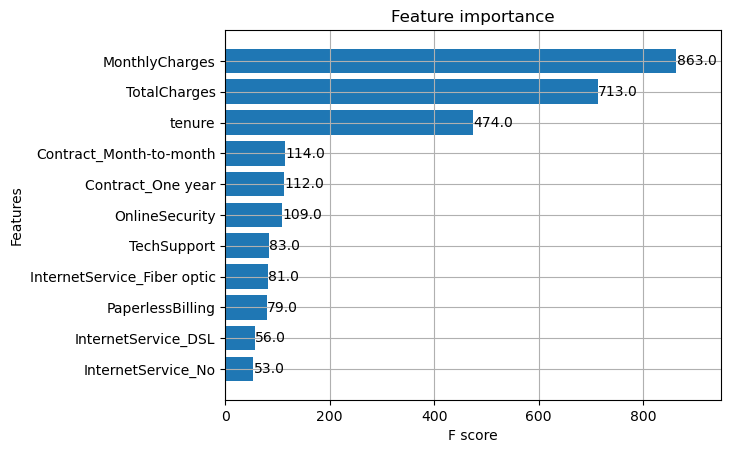

In [58]:
plot_importance(Best_XGB, height=0.8, max_num_features=15)

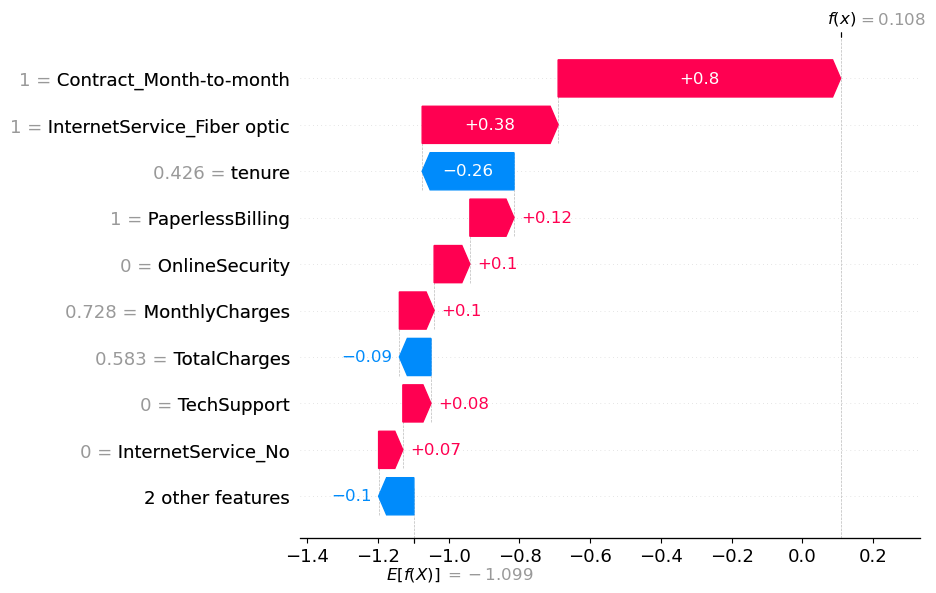

In [52]:
import shap
explainer = shap.Explainer(Best_XGB)
shap_values = explainer(X_test_selected_quantile_df)
shap.plots.waterfall(shap_values[0])

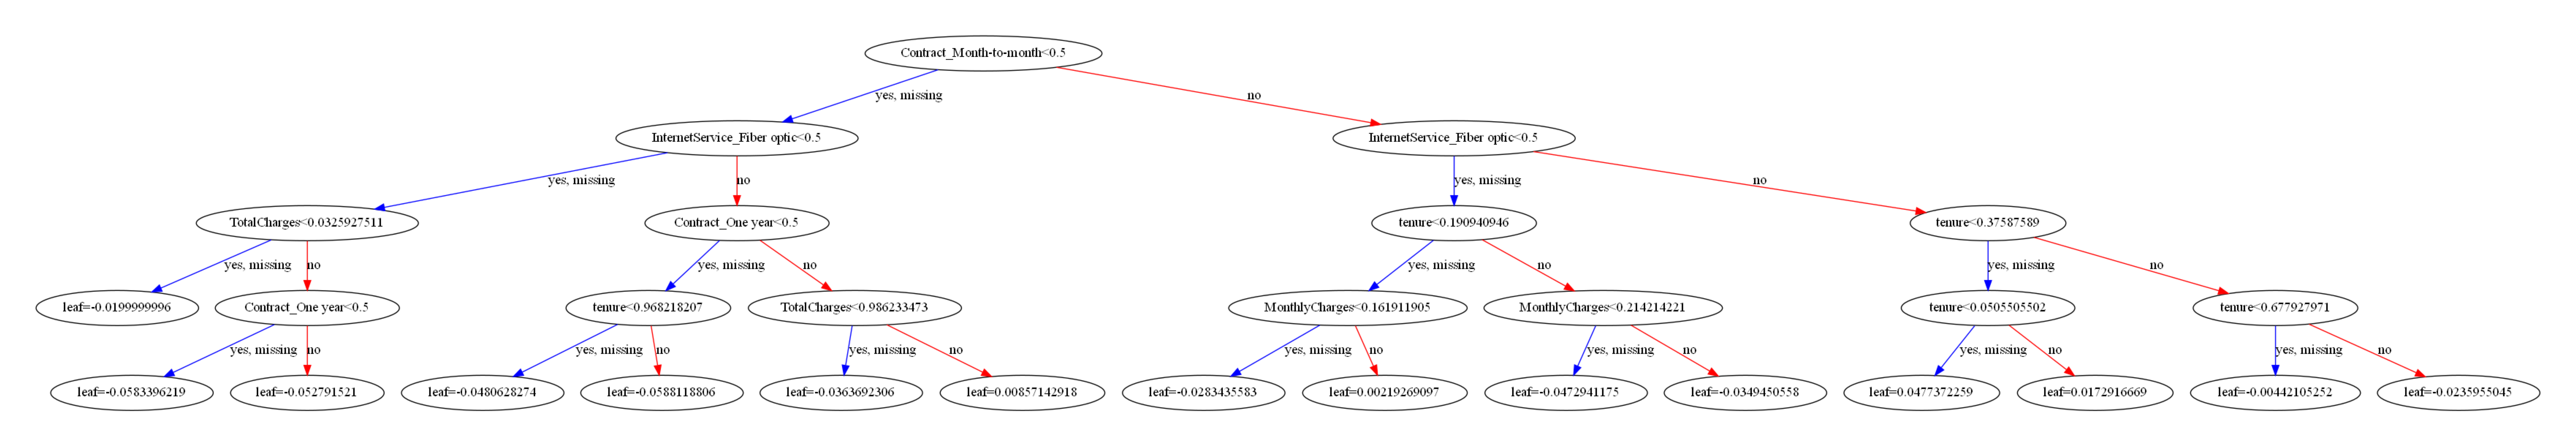

In [54]:
fig, ax = plt.subplots(figsize=(10, 20), dpi = 800)
plot_tree(Best_XGB, num_trees=0, ax = ax)
plt.show()

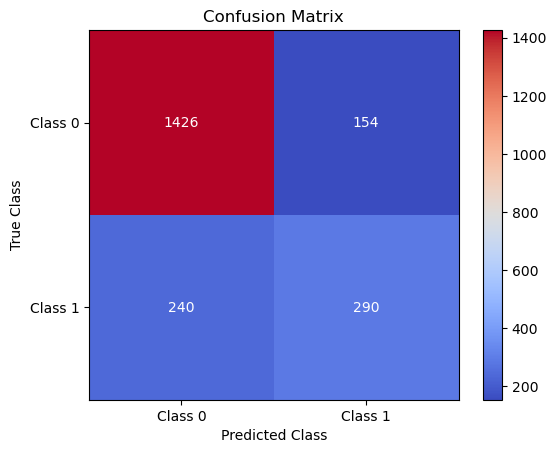

In [61]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test_ndarray, prediction)
plt.imshow(cm, cmap='coolwarm')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.yticks([0, 1], ['Class 0', 'Class 1'])
# add counts to the plot
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i][j]), ha='center', va='center', color='white')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()


- ROC_AUC: 0.7116491521375686
- Accuracy: 0.8075829383886256

In [ ]:
pca = PCA()

pipe = Pipeline([
    ('pca', PCA()),
    ('xgb', XGBClassifier())
])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'pca__n_components': ['mle', 50, 100],
    'xgb__max_depth': [4, 6],
    'xgb__learning_rate': [0.001, 0.01,  0.1, 1.0],
    'xgb__n_estimators': [50, 100, 200, 500],
    'xgb__subsample': [0.9, 1]
}
# Perform grid search over hyperparameters
search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
search.fit(X_train_selected_ndarray, Y_train_ndarray)

# Print best hyperparameters and their corresponding score
print("Best hyperparameters:", search.best_params_)
print("Best score:", search.best_score_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Feature_Engineering/Output/XGB_Accuracy.csv")
results.head(10)

[13:04:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best hyperparameters: {'pca__n_components': 'mle', 'xgb__learning_rate': 0.001, 'xgb__max_depth': 4, 'xgb__n_estimators': 500, 'xgb__subsample': 1}
Best score: 0.7950008253889645


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__n_estimators,param_xgb__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,7.637082,0.178640,0.006200,4.002572e-04,mle,0.001,4,500,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.803046,0.792893,0.784553,0.786585,0.807927,0.795001,0.009124,1
17,0.750760,0.024287,0.005303,4.009442e-04,mle,0.01,4,50,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.802030,0.789848,0.787602,0.786585,0.807927,0.794798,0.008584,2
23,7.612870,0.030321,0.006103,4.868617e-04,mle,0.01,4,500,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.796954,0.798985,0.788618,0.793699,0.795732,0.794798,0.003534,3
1,0.762741,0.044361,0.007600,3.261986e-03,mle,0.001,4,50,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.797970,0.791878,0.789634,0.796748,0.796748,0.794596,0.003245,4
33,0.831661,0.090113,0.006000,3.814697e-07,mle,0.1,4,50,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.798985,0.798985,0.787602,0.793699,0.792683,0.794391,0.004282,5
2,1.641621,0.032157,0.007401,1.355920e-03,mle,0.001,4,100,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.804061,0.789848,0.784553,0.788618,0.803862,0.794188,0.008170,6
5,3.120814,0.095610,0.006504,6.297106e-04,mle,0.001,4,200,1,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.803046,0.792893,0.783537,0.790650,0.800813,0.794188,0.007071,7
32,0.772640,0.040006,0.005400,4.897461e-04,mle,0.1,4,50,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.793909,0.796954,0.789634,0.793699,0.795732,0.793986,0.002485,8
0,0.803351,0.027807,0.006201,7.486348e-04,mle,0.001,4,50,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.803046,0.788832,0.786585,0.787602,0.803862,0.793985,0.007768,9
4,3.166425,0.045233,0.007101,8.018201e-04,mle,0.001,4,200,0.9,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.803046,0.789848,0.784553,0.787602,0.804878,0.793985,0.008338,10


In [78]:
Best_XGB = XGBClassifier(learning_rate = 0.01, max_depth = 4, n_estimators = 500, subsample = 1)
Best_XGB.fit(X_train_selected_ndarray, Y_train_ndarray)
prediction = Best_XGB.predict(X_test_selected_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

[20:22:04] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC_AUC: 0.7201158347265344
Accuracy: 0.8080568720379147


- ROC_AUC: 0.7201158347265344
- Accuracy: 0.8080568720379147

#### 7.2.3 StandardScaler tuning with CV

In [ ]:
pca = PCA()

pipe = Pipeline([
    ('pca', PCA()),
    ('xgb', XGBClassifier())
])

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'pca__n_components': ['mle', 50, 100],
    'xgb__max_depth': [4, 6],
    'xgb__learning_rate': [0.001, 0.01,  0.1, 1.0],
    'xgb__n_estimators': [50, 100, 200, 500]
}
# Perform grid search over hyperparameters
search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
search.fit(X_train_selected_sc_ndarray, Y_train_ndarray)

# Print best hyperparameters and their corresponding score
print("Best hyperparameters:", search.best_params_)
print("Best score:", search.best_score_)

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
pd.DataFrame.to_csv(results, path + "Feature_Engineering/Output/XGB_sc_ROCAUC.csv")
results.head(10)

[13:05:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best hyperparameters: {'pca__n_components': 'mle', 'xgb__learning_rate': 0.01, 'xgb__max_depth': 4, 'xgb__n_estimators': 500}
Best score: 0.8471455341823105


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,7.866520,0.147631,0.008001,0.000633,mle,0.01,4,500,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.843140,0.833172,0.847505,0.856536,0.855374,0.847146,0.008571,1
16,0.902673,0.113120,0.007000,0.000632,mle,0.1,4,50,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.844213,0.832464,0.845723,0.855958,0.855293,0.846730,0.008595,2
10,3.498347,0.059833,0.003602,0.004456,mle,0.01,4,200,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.843918,0.831319,0.847143,0.855687,0.853267,0.846267,0.008572,3
17,1.643269,0.071551,0.007587,0.002983,mle,0.1,4,100,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.838707,0.834075,0.841569,0.853133,0.854481,0.844393,0.008061,4
9,1.868126,0.061620,0.009122,0.003516,mle,0.01,4,100,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.842880,0.827029,0.846025,0.854704,0.850856,0.844299,0.009534,5
20,1.276325,0.034368,0.008007,0.004003,mle,0.1,6,50,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.837629,0.829654,0.841217,0.857479,0.850446,0.843285,0.009745,6
8,0.951212,0.137168,0.006404,0.003503,mle,0.01,4,50,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.841311,0.825983,0.846228,0.851721,0.848270,0.842703,0.009014,7
15,13.688721,0.292686,0.009037,0.002218,mle,0.01,6,500,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.838850,0.826883,0.840644,0.856351,0.850741,0.842694,0.010200,8
14,5.873947,0.154566,0.006505,0.003408,mle,0.01,6,200,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.840825,0.823716,0.842755,0.856231,0.848709,0.842447,0.010796,9
3,8.535132,0.252118,0.013244,0.004140,mle,0.001,4,500,"{'pca__n_components': 'mle', 'xgb__learning_ra...",0.841413,0.826024,0.845892,0.851351,0.847544,0.842445,0.008808,10


In [84]:
Best_XGB = XGBClassifier(learning_rate = 0.03, max_depth = 4, n_estimators = 500)
Best_XGB.fit(X_train_selected_sc_ndarray, Y_train_ndarray)
prediction = Best_XGB.predict(X_test_selected_sc_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

[20:22:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC_AUC: 0.7097384762359684
Accuracy: 0.8028436018957346


In [92]:
pipe = Pipeline([
    ('pca', PCA(n_components='mle')),
    ('xgb', XGBClassifier(learning_rate = 0.01, max_depth = 4, n_estimators = 200))
])
pipe.fit(X_train_ndarray, Y_train_ndarray)
prediction = pipe.predict(X_test_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)


[20:30:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC_AUC: 0.5634284690709339
Accuracy: 0.7658767772511849


In [98]:
Best_Bagging = BaggingClassifier(max_features = 0.6, max_samples = 0.5, n_estimators = 100)
Best_Bagging.fit(X_train_selected_ndarray, Y_train_ndarray)
prediction = Best_Bagging.predict(X_test_selected_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

ROC_AUC: 0.6927633150226893
Accuracy: 0.795260663507109


In [54]:
Best_Bagging = BaggingClassifier(max_features = 0.6, max_samples = 0.6, n_estimators = 300)
Best_Bagging.fit(X_train_selected_mmx_ndarray, Y_train_ndarray)
prediction = Best_Bagging.predict(X_test_selected_mmx_ndarray)

auc_score = roc_auc_score(Y_test_ndarray, prediction)
print("ROC_AUC:", auc_score)

accuracy = accuracy_score(Y_test_ndarray, prediction)
print("Accuracy:", accuracy)

ROC_AUC: 0.6874134224982088
Accuracy: 0.7919431279620853


- ROC_AUC: 0.7094578457129209
- Accuracy: 0.8080568720379147

## 8. Deep Learning_Selected_Features

In [43]:
from sklearn.metrics import confusion_matrix

In [44]:
from sklearn.metrics import confusion_matrix

class ANN_Model:
    def __init__(self, input_dim, seed=42):
        self.input_dim = input_dim
        self.seed = seed

    def create_model(self):
        model = nn.Sequential(
            nn.Linear(self.input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        return model

    def evaluate(self, X_train, y_train, X_test, y_test, cv=10, epochs=10, batch_size=32, model_path="model.pt"):
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = self.create_model().to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters())
        kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        val_scores = []
        test_scores = []
        for train_idx, val_idx in kfold.split(X_train, y_train):
            X_train_fold = torch.tensor(X_train[train_idx], dtype=torch.float32).to(device)
            y_train_fold = torch.tensor(y_train[train_idx], dtype=torch.float32).to(device)
            X_val_fold = torch.tensor(X_train[val_idx], dtype=torch.float32).to(device)
            y_val_fold = torch.tensor(y_train[val_idx], dtype=torch.float32).to(device)

            for epoch in range(epochs):
                model.train()
                optimizer.zero_grad()
                y_pred = model(X_train_fold)
                loss = criterion(y_pred, y_train_fold)
                loss.backward()
                optimizer.step()

            model.eval()
            y_pred_val = model(X_val_fold)

            val_acc = ((y_pred_val >= 0.5).squeeze().float() == y_val_fold).float().mean().item()
            val_scores.append(val_acc)

            X_test_fold = torch.tensor(X_test, dtype=torch.float32).to(device)
            y_test_fold = torch.tensor(y_test, dtype=torch.float32).to(device)
            y_pred_test = model(X_test_fold)
            test_acc = ((y_pred_test >= 0.5).squeeze().float() == y_test_fold).float().mean().item()

            test_scores.append(test_acc)
        
        # save model
        torch.save(model.state_dict(), model_path)

        print("Validation Accuracy: %.2f%% (%.2f%%)" % (np.mean(val_scores)*100, np.std(val_scores)*100))
        print("Test Accuracy: %.2f%%" % (np.mean(test_scores)*100))

    def confusion_matrix(self, X_test, y_test, model_path):
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = self.create_model().to(device)
        model.load_state_dict(torch.load(model_path))
        model.eval()
        y_pred = (model(torch.tensor(X_test, dtype=torch.float32).to(device)) >= 0.5).squeeze().float()
        cm = confusion_matrix(y_test, y_pred.cpu())
        return cm


In [45]:
ann_model = ANN_Model(input_dim=X_train_selected_ndarray.shape[1])
ann_model.evaluate(X_train_selected_ndarray, Y_train_ndarray, X_test_selected_ndarray, Y_test_ndarray, cv=5, epochs=30, batch_size=32)

Validation Accuracy: 67.42% (3.07%)
Test Accuracy: 68.87%


In [46]:
ann_model = ANN_Model(input_dim=X_train_selected_sc_ndarray.shape[1])
ann_model.evaluate(X_train_selected_sc_ndarray, Y_train_ndarray, X_test_selected_sc_ndarray, Y_test_ndarray, cv=5, epochs=30, batch_size=32)

Validation Accuracy: 66.55% (4.20%)
Test Accuracy: 68.34%


In [47]:
ann_model = ANN_Model(input_dim=X_train_selected_mmx_ndarray.shape[1])
ann_model.evaluate(X_train_selected_mmx_ndarray, Y_train_ndarray, X_test_selected_mmx_ndarray, Y_test_ndarray, cv=5, epochs=30, batch_size=32)

Validation Accuracy: 69.69% (3.86%)
Test Accuracy: 71.73%


In [48]:
cm = ann_model.confusion_matrix(X_test_selected_mmx_ndarray, Y_test_ndarray, "model.pt")
print(cm)

[[1423  157]
 [ 278  252]]


In [50]:
ann_model = ANN_Model(input_dim=X_train_selected_quantile_ndarray.shape[1])
ann_model.evaluate(X_train_selected_quantile_ndarray, Y_train_ndarray, X_test_selected_quantile_ndarray, Y_test_ndarray, cv=5, epochs=20, batch_size=32)
cm = ann_model.confusion_matrix(X_test_selected_mmx_ndarray, Y_test_ndarray, "model.pt")
print(cm)

Validation Accuracy: 72.80% (0.04%)
Test Accuracy: 74.88%
[[1580    0]
 [ 530    0]]


In [51]:
ann_model = ANN_Model(input_dim=X_train_quantile_ndarray.shape[1])
ann_model.evaluate(X_train_quantile_ndarray, Y_train_ndarray, X_test_quantile_ndarray, Y_test_ndarray, cv=5, epochs=30, batch_size=32)
cm = ann_model.confusion_matrix(X_test_quantile_ndarray, Y_test_ndarray, "model.pt")
print(cm)

Validation Accuracy: 67.11% (4.78%)
Test Accuracy: 69.18%
[[1405  175]
 [ 245  285]]


In [52]:
ann_model = ANN_Model(input_dim=X_train_ndarray.shape[1])
ann_model.evaluate(X_train_ndarray, Y_train_ndarray, X_test_ndarray, Y_test_ndarray, cv=5, epochs=30, batch_size=32)

Validation Accuracy: 60.89% (3.58%)
Test Accuracy: 62.33%


In [54]:
ann_model = ANN_Model(input_dim=X_train_sc_ndarray.shape[1])
ann_model.evaluate(X_train_sc_ndarray, Y_train_ndarray, X_test_sc_ndarray, Y_test_ndarray, cv=5, epochs=30, batch_size=32)

Validation Accuracy: 65.92% (5.60%)
Test Accuracy: 68.02%


In [55]:
ann_model = ANN_Model(input_dim=X_train_mmx_ndarray.shape[1])
ann_model.evaluate(X_train_mmx_ndarray, Y_train_ndarray, X_test_mmx_ndarray, Y_test_ndarray, cv=5, epochs=30, batch_size=32)

Validation Accuracy: 66.97% (4.92%)
Test Accuracy: 69.02%


The best result is 72.38%, a little bit higher than the 64% accuracy from original data